# Exercise 2: Boosting

## Do not start the exercise until you fully understand the submission guidelines.


* The homework assignments are executed automatically. 
* Failure to comply with the following instructions will result in a significant penalty. 
* Appeals regarding your failure to read these instructions will be denied. 
* Kind reminder: the homework assignments contribute 60% of the final grade.


## Read the following instructions carefully:

1. This Jupyter notebook contains all the step-by-step instructions needed for this exercise.
1. Write **efficient**, **vectorized** code whenever possible. Some calculations in this exercise may take several minutes when implemented efficiently, and might take much longer otherwise. Unnecessary loops will result in point deductions.
1. You are responsible for the correctness of your code and should add as many tests as you see fit to this jupyter notebook. Tests will not be graded nor checked.
1. You are allowed to use functions and methods from the [Python Standard Library](https://docs.python.org/3/library/).
1. Your code must run without errors. Use at least `numpy` 1.15.4. Any code that cannot run will not be graded.
1. Write your own code. Cheating will not be tolerated.
1. Submission includes a zip file that contains this notebook, with your ID as the file name. For example, `hw1_123456789_987654321.zip` if you submitted in pairs and `hw1_123456789.zip` if you submitted the exercise alone. The name of the notebook should follow the same structure.
   
Please use only a **zip** file in your submission.

---
---

## Please sign that you have read and understood the instructions: 

316492776
318900016

---
---


In [215]:
# Import necessary libraries
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.colors import ListedColormap
from sklearn.datasets import load_iris, make_classification
from sklearn.ensemble import (
    AdaBoostClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier,
)
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from tqdm.auto import tqdm
import pandas as pd

sns.set_theme()
np.random.seed(42)

# Design your algorithm
Make sure to describe the algorithm, its limitations, and describe use-cases.

Adaboost is a boosting algorithm, which uses a combination of weak learners $\{h_t\}_{i=1}^{T}$ to achieve a stronger model $H_T$ with less error on the training data and also less biased compared to a stronger "single" learner.

It can be widely used to solve binary classification problems, especially when the dataset is quite small since it uses a different subset every step and avoids overfit (which is also that to each learner being simple and hence unable to capture complex relations specific to its seen subset).

Our loss function is an exponential loss $\ell (H)=\sum_{i=1}^{n}{e^{−y_i H(x_i)}}$

The model is defined by $H_T(x) = \sum_{t=1}^{T}{\alpha_{t} \cdot h_t(x)}$.

$\alpha_t$ here are the weights / step-sizes, and we perform line-search to obtain them in each iteration.

In each step, we find the best weak learner ($h \in \mathbb{H}$) to add to our ensamble, by minimizing the weighted classification error of the current strong learner. It seeks to improve the most "painful" examples, with greater $H$ loss having more weight in the sum making them more important for $h$ to succeed on - $\underset{h \in \mathbb{H}}{\argmin}{\sum_{i=1}^{n}{\frac{\partial \ell}{\partial H(x_i)}h(x_i)}}$

In class, we defined $w_i \coloneqq e^{-y_i H(x_i)}$ up to a normalization factor than sums $\{w_i\}_{i=1}^{n}$ to 1.
We also saw that the improvement that we seek equals $\underset{h \in \mathbb{H}}{\argmin} \sum_{i : h(x_i) \neq y_i} w_i$, which is (by definition of $w_i$) the contribution to the *general* loss ($\ell (H)$) of all misclassified examples by the *weak* learner.

The most obvious limitation of the algorithm as seen in class that it is binary, i.e. both $y_i \in \{+1,−1\}$ and also the weak learners: $h \in \mathbb{H}$ are binary, $\forall x, h(x_i) \in \{+1,−1\}$, which is obviously not true for all tasks. However, we have read that it can be generalized to multiple classes or bounded intervals of values.
> It is important to note that $H$ is *not* binary since $H_T(x) = \sum_{t=1}^{T}{\alpha_{t} \cdot h_t(x)}$

Although it is pretty fast, the learners must be trained sequentially, unlike RF for example where the weak learners are independant and therefore can be trained simultaniously.

Also, like all models, it's not completely immune to overfitting, as seen in slides 48-52 in the presentation in class, so one needs to be careful when choosing the number of trees T.

# Your implementations
You may add new cells, write helper functions or test code as you see fit.
Please use the cell below and include a description of your implementation.
Explain code design consideration, algorithmic choices and any other details you think is relevant to understanding your implementation.
Failing to explain your code will lead to point deductions.

We implemented our algorithm according to the pseudo-code on slide 34. On each step - we create a new weak learner. Then, we calculate $\epsilon_t$ and $\alpha_t$, append the learner and its weight ($h_t, \alpha_t$) to our list of learners, and finally update $w_i$ according to the weak learner predictions (there is no need to calculate $H$ since we already have the partial value up to that iteration).

In order to make the code more readable (mostly for us :) ), we added implementation of the strong learner $H$ and the loss $Z$/$\ell(H)$. We also added an early stopping mechanism, in case the weak learner performs worse than random.

> If at some point $\epsilon_t=0$ meaning $\sum_{i : h(x_i) \neq y_i} w_i=0$, since $\forall i, w_i > 0$ we get that the sum is over 0 samples, or in other words $h$ separates the data perfectly, so we stop early in that case, and return $h$ as our only estimator.
> This edge-case is needed to handle data which is too easy, since $\alpha_t$ will be infinite in that case.

The most important hyperparameter is the number of weak learner, T, which we obviously support in our implementation.
In theory, $\mathbb{H}$ can be anything, but in our implementation they are always 1-depth decision stumps since this is what we discussed in class. In contrast to sklearn, we also do not support different learning rates, as we did not see any justification to do that since our algorithm runs relatively fast and chaning lr can harm the accuracy / running time (as discussed in https://medium.com/@chaudhurysrijani/tuning-of-adaboost-with-computational-complexity-8727d01a9d20).



In [216]:
class AdaBoostCustom:
    def __init__(self, T: int = 50, verbose: bool = False):
        self.T = T
        self.verbose = verbose

    def fit(self, X: np.ndarray, y: np.ndarray):
        self.alphas = []
        self.estimators_ = []  # to match with sklearn so functions can work on both
        
        w = np.ones_like(y) / len(y)
        for t in tqdm(range(self.T), disable=not self.verbose, desc="t"):
            if self.verbose:
                print(f"After {t} models, Z=loss(H)={self.Z(X,y)}")
            h = DecisionTreeClassifier(max_depth=1)
            h.fit(X=X, y=y, sample_weight=w)
            epsilon = (w * (h.predict(X=X) != y)).sum()
            if epsilon >= 0.5:
                if self.verbose:
                    print(f"Stopping eraly! h is not better than random. {epsilon=}")
                return self
            if epsilon == 0:
                if self.verbose:
                    print(f"Stopping eraly! h separates the data perfectly. {epsilon=}")
                self.estimators_ = [h]
                self.alphas = [1.0]
                return self

            alpha = 0.5 * (np.log(1 - epsilon) - np.log(epsilon))
            # update alphas, models and w
            self.estimators_.append(h)
            self.alphas.append(alpha)
            w *= np.exp(-alpha * h.predict(X) * y)
            w /= 2 * (epsilon * (1 - epsilon)) ** 0.5
        return self

    def H(self, X: np.ndarray) -> np.ndarray:
        return np.array(
            [
                alpha * model.predict(X)
                for alpha, model in zip(self.alphas, self.estimators_)
            ]
        ).sum(axis=0)

    def Z(self, X: np.ndarray, y: np.ndarray) -> float:
        return np.exp(-y * self.H(X)).sum()

    def predict(self, X: np.ndarray) -> np.ndarray:
        predictions = np.sign(self.H(X))
        return predictions

# Generate data
Please use the cell below to discuss your dataset choice and why it is appropriate (or not) for this algorithm.

For the data generation. We chose to use the IRIS dataset
The IRIS Flower dataset is a well known dataset that works well with boosting algorithms, easy to classify and it contains 4 features:
1. Sepal length
2. Sepal width
3. Petal length
4. Petal width

And 3 classes (labels): Setosa, Versicolor, Virginica that marked as 0, 1, 2

For sampling our implementation, we disabled one of the classes of IRIS in order to handle a binary-labeled dataset

In [217]:
# Generate a dataset with the same parameters as IRIS dataset

iris = load_iris()
boolean_mask = iris.target < 2 # iris has 3 classes, we want 2
X = iris.data[boolean_mask] 
y = iris.target[boolean_mask] #.astype(int) * 2 - 1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # 70% training and 30% test

In [218]:
X.shape

(100, 4)

In [219]:
y.shape

(100,)

In [220]:
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [221]:
total_classes = len(np.unique(y))
print(f"There are {total_classes} classes")

There are 2 classes


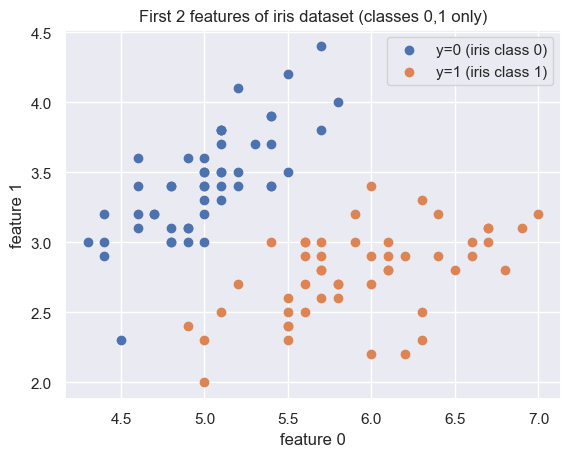

In [222]:
X_neg = X[y==0]
X_pos = X[y==1]
plt.scatter(X_neg[:, 0], X_neg[:, 1], label="y=0 (iris class 0)")
plt.scatter(X_pos[:, 0], X_pos[:, 1], label="y=1 (iris class 1)")
plt.legend()
plt.title("First 2 features of iris dataset (classes 0,1 only)")
plt.xlabel("feature 0")
plt.ylabel("feature 1")
plt.show()

# AdaBoost demonstration 
Demonstrate your AdaBoost implementation.

Add plots and figures. 

Please use the cell below to describe your results and tests.

Describe the difference between your implementation and the sklearn implementation. Hint: you can look at the documentation.

In order to demonstrate our result, we chose to use the following comparisons:
1. Comparison between the methods:
   * We made a comparison between the SKLearn Model and the Custom Model, while comparing the true labels / predicted labels of each one of the models using a confusion matrix, and also compare between their accuracies (In the bottom of the notebook, a comparison of all our experiments)
   * The accuracies are compared both for train set and both for test set
   * Since IRIS dataset is a well known dataset exact for these models, we've found a very high accuracy for both models. Due to the clear seperation between classes and the fact the dataset is not noisy, it got very high results of a perfect accuracy
3. Comparison between the features:
   * The IRIS dataset has 4 features, and we compared the accuracy between all the possible feature pairs
   * Also, we built a boundry graph for each one of the pairs (A boundry graph can be built just for 2 features). While the train samples are colored with red and blue, and the predicted samples of the test set are colored with black and white (red<->black and blue<->white)
   * We found that the best combination are when one feature is Sepal and the other is Petal

In [223]:
def print_plots(model, X_train, X_test, y_train, y_test, extra_title=None):
    plot_idx_x = 0
    plot_idx_y = 0
    plot_step = 0.02  # fine step width for decision surface contours
    plot_step_coarser = 0.5  # step widths for coarse classifier guesses
    cmap = plt.cm.RdYlBu
    plot_colors_train = "rb"
    plot_colors_test = "kw"
    class_names = "AB"
    accuracies_list_internal = []

    list_range = range(len(X_train[1]))
    all_pairs = [(a, b) for idx, a in enumerate(list_range) for b in list_range[idx + 1:]]
    num_of_rows = int(len(all_pairs) / 2) if len(all_pairs) % 2 == 0 else int(len(all_pairs) / 2) + 1
    fig, axs = plt.subplots(num_of_rows, 2, figsize=(15, 20))
    for pair in all_pairs:
        X_train_pair = X_train[:,pair]
        X_test_pair = X_test[:,pair]
        
        # Train
        res = model.fit(X_train_pair, y_train)
        #Predict the response for test dataset
        y_pred = res.predict(X_test_pair)
        y_train_pred = res.predict(X_train_pair)

        train_acc = accuracy_score(y_train, y_train_pred)
        test_acc = accuracy_score(y_test, y_pred)
        # Create a title for each column and the console by using str() and
        # slicing away useless parts of the string
        model_title = type(model).__name__[: -len("Classifier")]

        if extra_title:
            model_title += f" {extra_title}"
        
        model_details = model_title
        if hasattr(model, "estimators_"):
            model_details += " with {} estimators".format(len(model.estimators_))
        print(f"{model_details} with features {pair} has a score of\nTrain: {train_acc}\nTest: {test_acc}")

        accuracies_list_internal.append({
            'title': pair,
            'train_acc': train_acc,
            'test_acc': test_acc
        })
        
        axs[plot_idx_x, plot_idx_y].plot()
        axs[plot_idx_x, plot_idx_y].set_title(f"{model_title} decision boundary with features {pair}", fontsize=9)

        disp = DecisionBoundaryDisplay.from_estimator(
            model,
            X_train_pair,
            cmap=plt.cm.RdBu,
            response_method="predict",
            ax=axs[plot_idx_x, plot_idx_y],
            xlabel='x',
            ylabel='y',
        )

        x_min, x_max = disp.xx0.min(), disp.xx0.max()
        y_min, y_max = disp.xx1.min(), disp.xx1.max()

        for i, n, c1, c2 in zip(np.unique(y_train), class_names, plot_colors_train, plot_colors_test):
            idx1 = np.where(y_train == i)
            axs[plot_idx_x, plot_idx_y].scatter(
                X_train_pair[idx1, 0],
                X_train_pair[idx1, 1],
                c=c1,
                marker="o",
                s=20,
                #edgecolor="k",
                label="Class %s" % n,
            )

            idx2 = np.where(y_pred == i)
            axs[plot_idx_x, plot_idx_y].scatter(
                X_test_pair[idx2, 0],
                X_test_pair[idx2, 1],
                c=c2,
                marker="*",
                s=20,
                #edgecolor="k",
                label="Class %s" % n,
            )
        
        #plot_idx_x += 1
        plot_idx_y += 1  # move on to the next plot in sequence
        if (plot_idx_y % 2 == 0):
            plot_idx_x += 1
            plot_idx_y = 0
    
    plt.suptitle(f"Classifiers on feature subsets of the {extra_title} dataset", fontsize=12)
    plt.axis("tight")
    plt.tight_layout(h_pad=1, w_pad=1, pad=10)
    plt.show()

    accuracies_list_df = pd.DataFrame.from_records(accuracies_list_internal)
    accuracies_list_df.plot.bar(x='title', y=['train_acc', 'test_acc'])

Accuracy of AdaBoostSklearn:
Train:1.0
Test:1.0


/Users/scohen6/projects/idc_msc/advanced-ml/exc1/venv/lib/python3.13/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


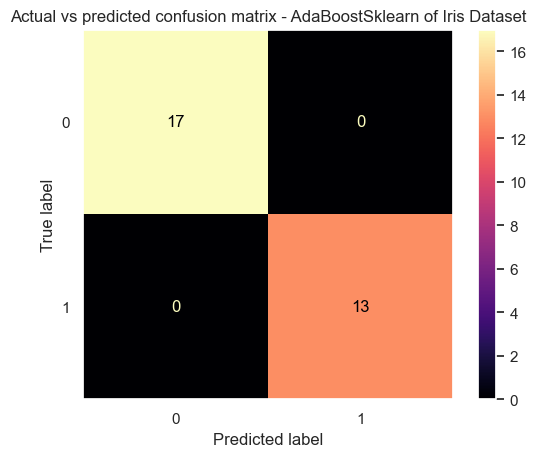

/Users/scohen6/projects/idc_msc/advanced-ml/exc1/venv/lib/python3.13/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/scohen6/projects/idc_msc/advanced-ml/exc1/venv/lib/python3.13/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/scohen6/projects/idc_msc/advanced-ml/exc1/venv/lib/python3.13/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/scohen6/projects/idc_msc/advanced-ml/exc1/venv/lib/python3.13/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning:

AdaBoost Iris with 10 estimators with features (0, 1) has a score of
Train: 1.0
Test: 1.0
AdaBoost Iris with 1 estimators with features (0, 2) has a score of
Train: 1.0
Test: 1.0
AdaBoost Iris with 1 estimators with features (0, 3) has a score of
Train: 1.0
Test: 1.0
AdaBoost Iris with 1 estimators with features (1, 2) has a score of
Train: 1.0
Test: 1.0
AdaBoost Iris with 1 estimators with features (1, 3) has a score of
Train: 1.0
Test: 1.0
AdaBoost Iris with 1 estimators with features (2, 3) has a score of
Train: 1.0
Test: 1.0


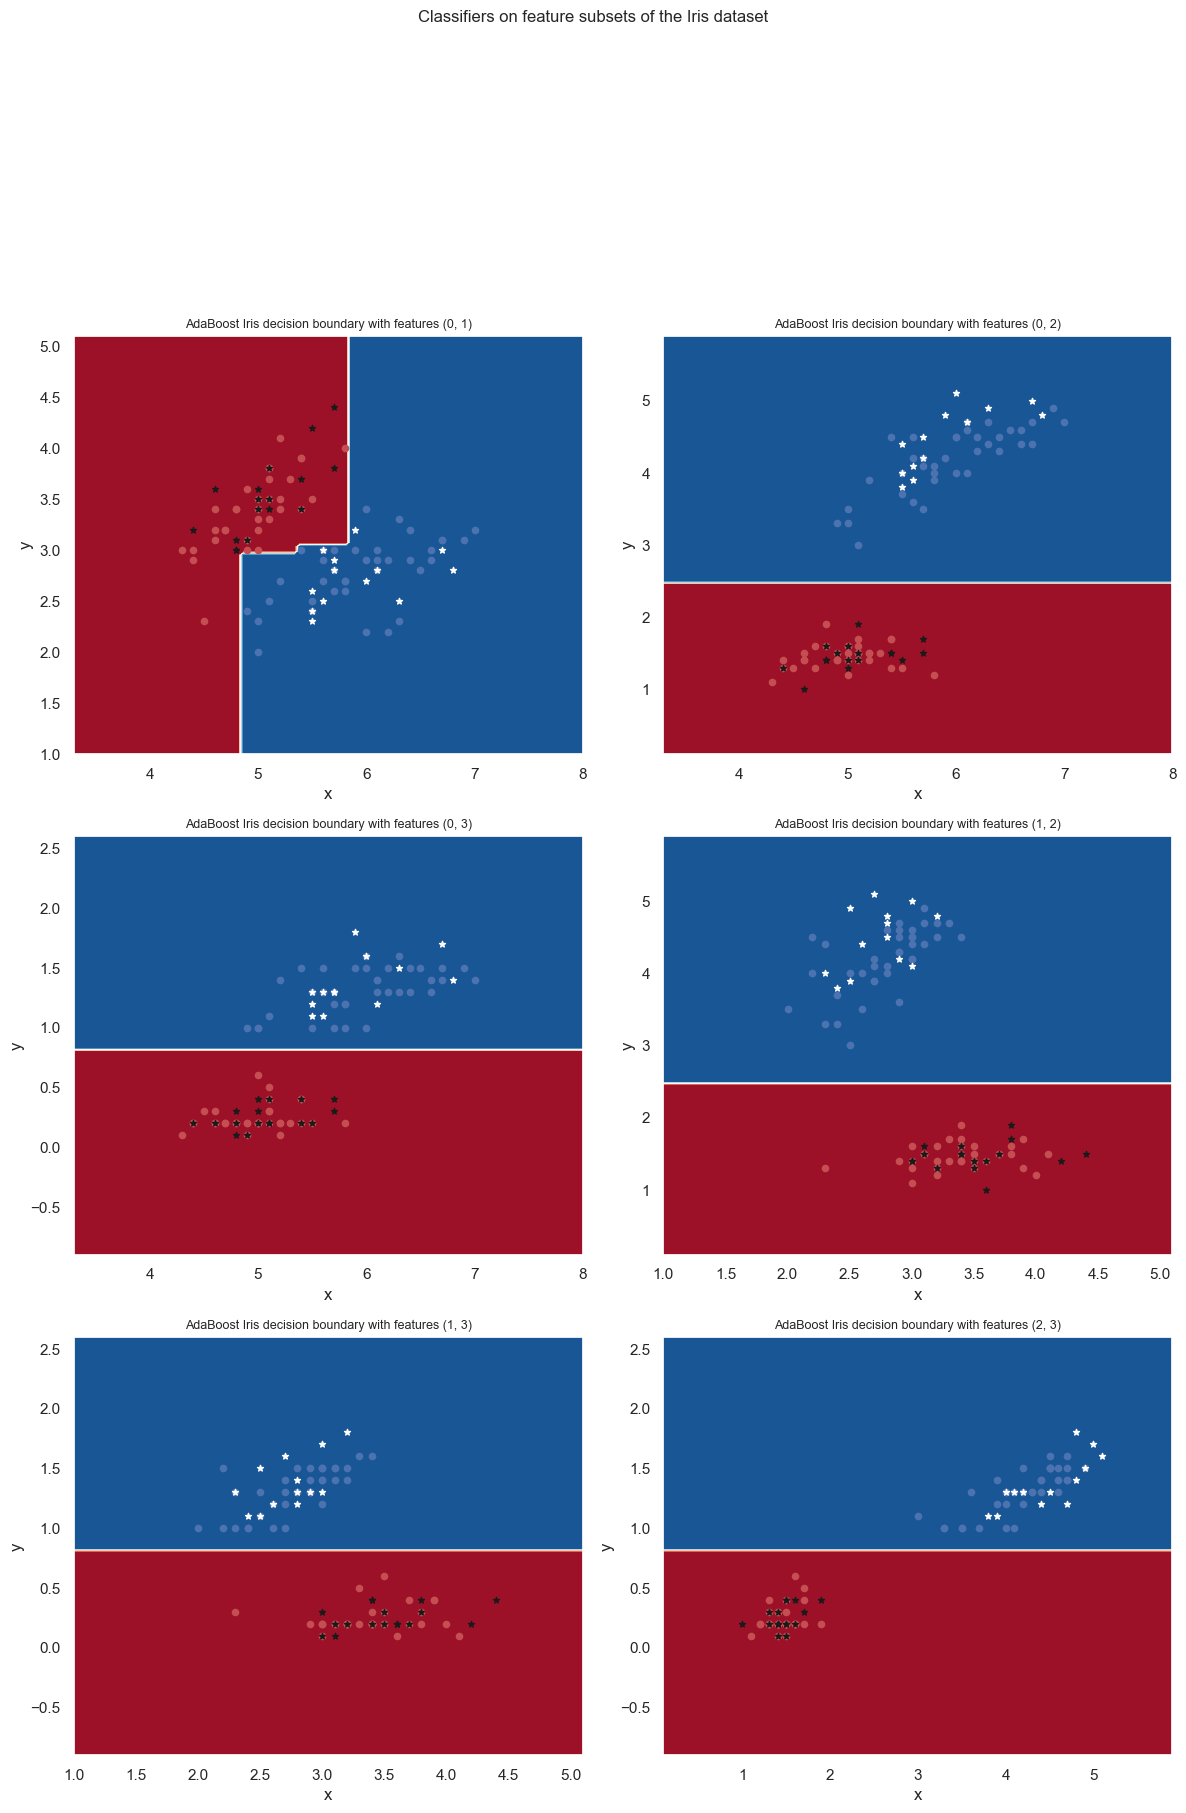

Accuracy of AdaBoostCustom:
Train:1.0
Test:1.0


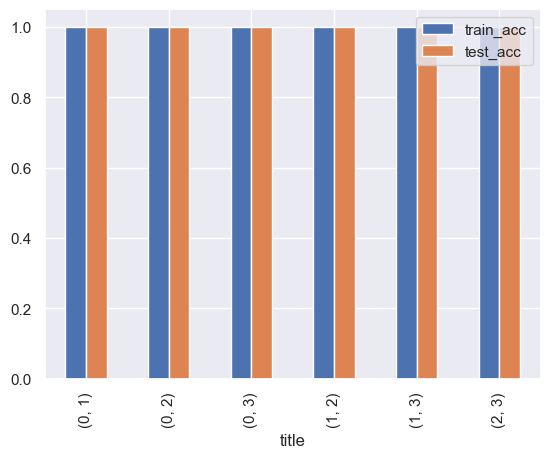

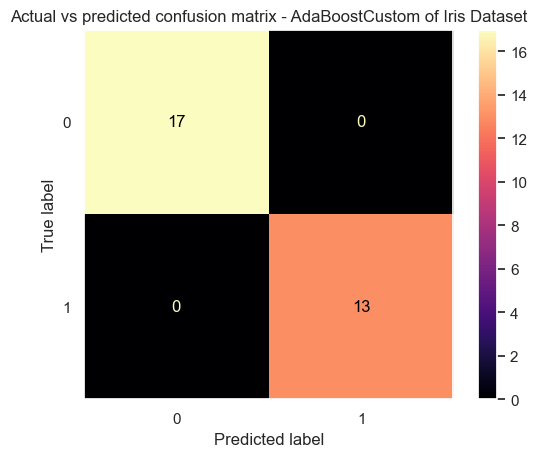

AdaB Iris with 10 estimators with features (0, 1) has a score of
Train: 0.9285714285714286
Test: 0.9
AdaB Iris with 1 estimators with features (0, 2) has a score of
Train: 1.0
Test: 1.0
AdaB Iris with 1 estimators with features (0, 3) has a score of
Train: 1.0
Test: 1.0
AdaB Iris with 1 estimators with features (1, 2) has a score of
Train: 1.0
Test: 1.0
AdaB Iris with 1 estimators with features (1, 3) has a score of
Train: 1.0
Test: 1.0
AdaB Iris with 1 estimators with features (2, 3) has a score of
Train: 1.0
Test: 1.0


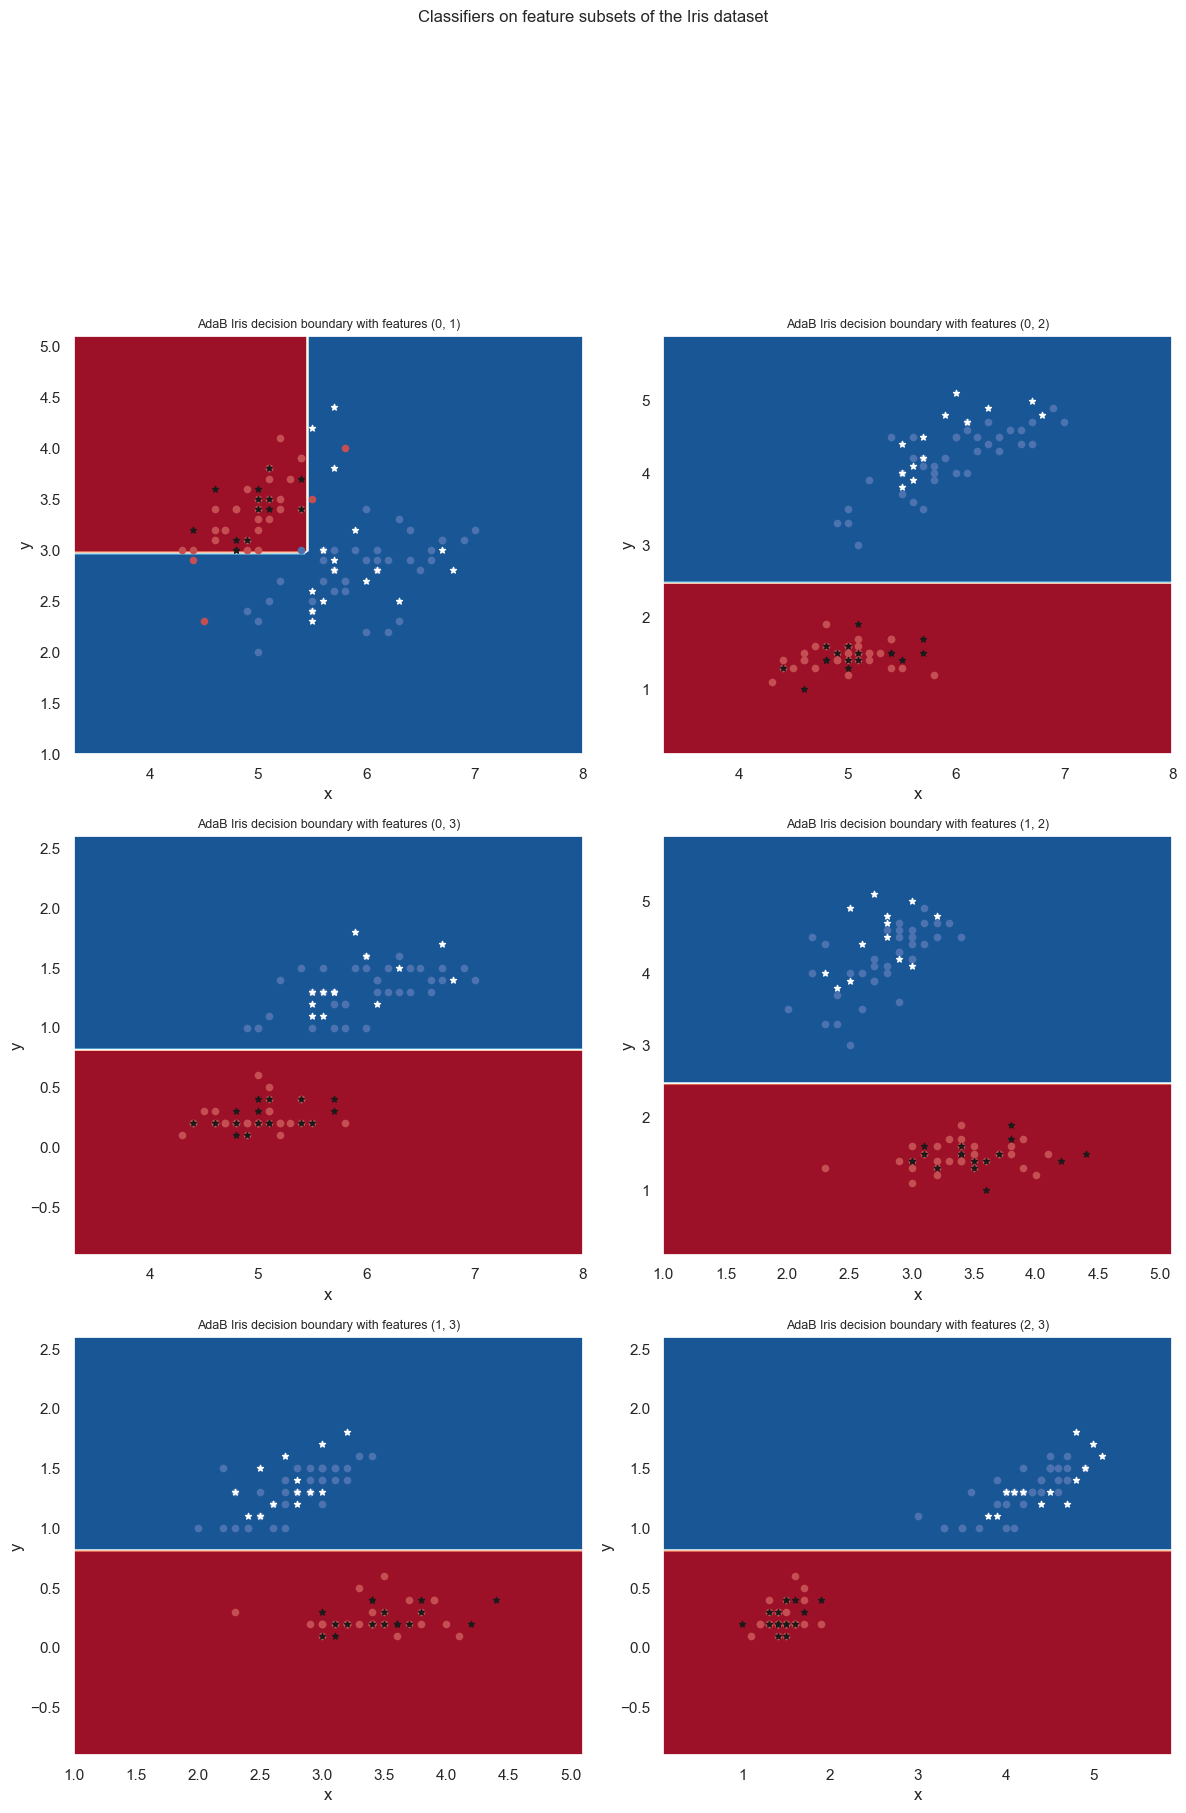

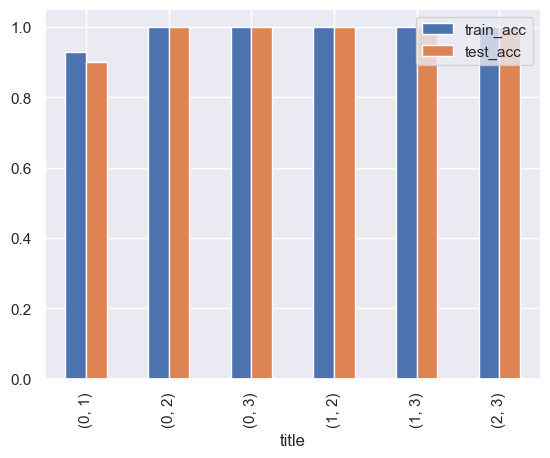

In [224]:
models = [
    AdaBoostClassifier(n_estimators=10, random_state=42),
    AdaBoostCustom(T=10, verbose=False)
]

accuracies_list = []

for model in models:
    # Train Adaboost Classifer
    res = model.fit(X_train, y_train)
    
    #Predict the response for test dataset
    y_train_pred = res.predict(X_train)
    y_pred = res.predict(X_test)

    model_title = type(model).__name__.replace("Classifier", "Sklearn")

    accuracies_list.append({
        "title": f"{model_title} of Iris Dataset",
        "train_acc": accuracy_score(y_train, y_train_pred),
        "test_acc": accuracy_score(y_test, y_pred)
    })
    
    # Model Accuracy, how often is the classifier correct?
    print(f"Accuracy of {model_title}:\nTrain:{accuracy_score(y_train, y_train_pred)}\nTest:{accuracy_score(y_test, y_pred)}")
    
    matrix_plot = confusion_matrix(y_test, y_pred)
    cm_display = ConfusionMatrixDisplay(confusion_matrix=matrix_plot)
    cm_display.plot(cmap="magma")
    plt.title(
        f"Actual vs predicted confusion matrix - {model_title} of Iris Dataset"
    )
    plt.grid(False)
    plt.show()

    print_plots(model, X_train, X_test, y_train, y_test, "Iris")

# Generate additional data sets
Generate at least two experimental datasets with binary labels, designed to demonstrate specific properties of AdaBoost (e.g., handling noise or overfitting).

Add plots and figures.

Please use the cell below to describe your suggested approach in detail. Use formal notations where appropriate.

Describe and discuss your results.

We generated two experminental datasets:
1. A dataset with a low space seperation (The space between the label classes). A smaller value reduces the space and thus makes classification harder. Therefore, we put a dataset with a value of 0.2 which is a low seperation
2. A dataset with a high flip value. Flip is the fraction of samples whose class is assigned randomly. By default is 0.01. We chose to generate a dataset with a higher value to make a large samples with a random class assignment which makes the classification harder since the dataset is much noisy and tends to overfitting
3. A dataset without a shuffle. Unshuffled data leads to divergence, loss spikes, and suboptimal training

We found that for both combinations, the accuracy is much lower than in the Iris dataset, and moreover, there are much large difference between train accuracy and test accuracy

Accuracy of AdaBoostSklearn:
Train:0.7428571428571429
Test:0.5166666666666667


/Users/scohen6/projects/idc_msc/advanced-ml/exc1/venv/lib/python3.13/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


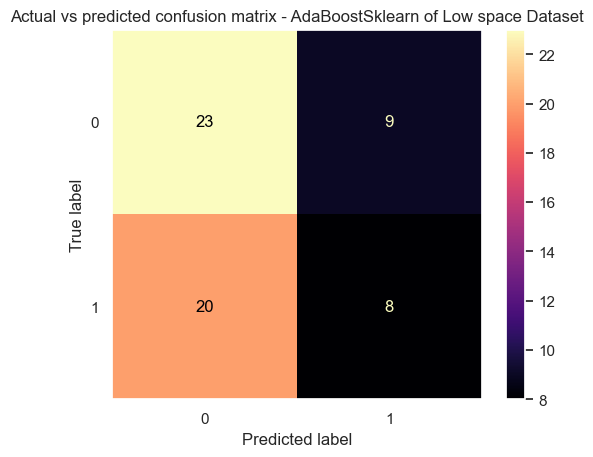

/Users/scohen6/projects/idc_msc/advanced-ml/exc1/venv/lib/python3.13/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/scohen6/projects/idc_msc/advanced-ml/exc1/venv/lib/python3.13/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/scohen6/projects/idc_msc/advanced-ml/exc1/venv/lib/python3.13/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/scohen6/projects/idc_msc/advanced-ml/exc1/venv/lib/python3.13/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning:

AdaBoost Low space Dataset with 10 estimators with features (0, 1) has a score of
Train: 0.7285714285714285
Test: 0.45
AdaBoost Low space Dataset with 10 estimators with features (0, 2) has a score of
Train: 0.7357142857142858
Test: 0.5
AdaBoost Low space Dataset with 10 estimators with features (0, 3) has a score of
Train: 0.6714285714285714
Test: 0.5
AdaBoost Low space Dataset with 10 estimators with features (1, 2) has a score of
Train: 0.7785714285714286
Test: 0.5333333333333333
AdaBoost Low space Dataset with 10 estimators with features (1, 3) has a score of
Train: 0.7285714285714285
Test: 0.5333333333333333
AdaBoost Low space Dataset with 10 estimators with features (2, 3) has a score of
Train: 0.6928571428571428
Test: 0.5833333333333334


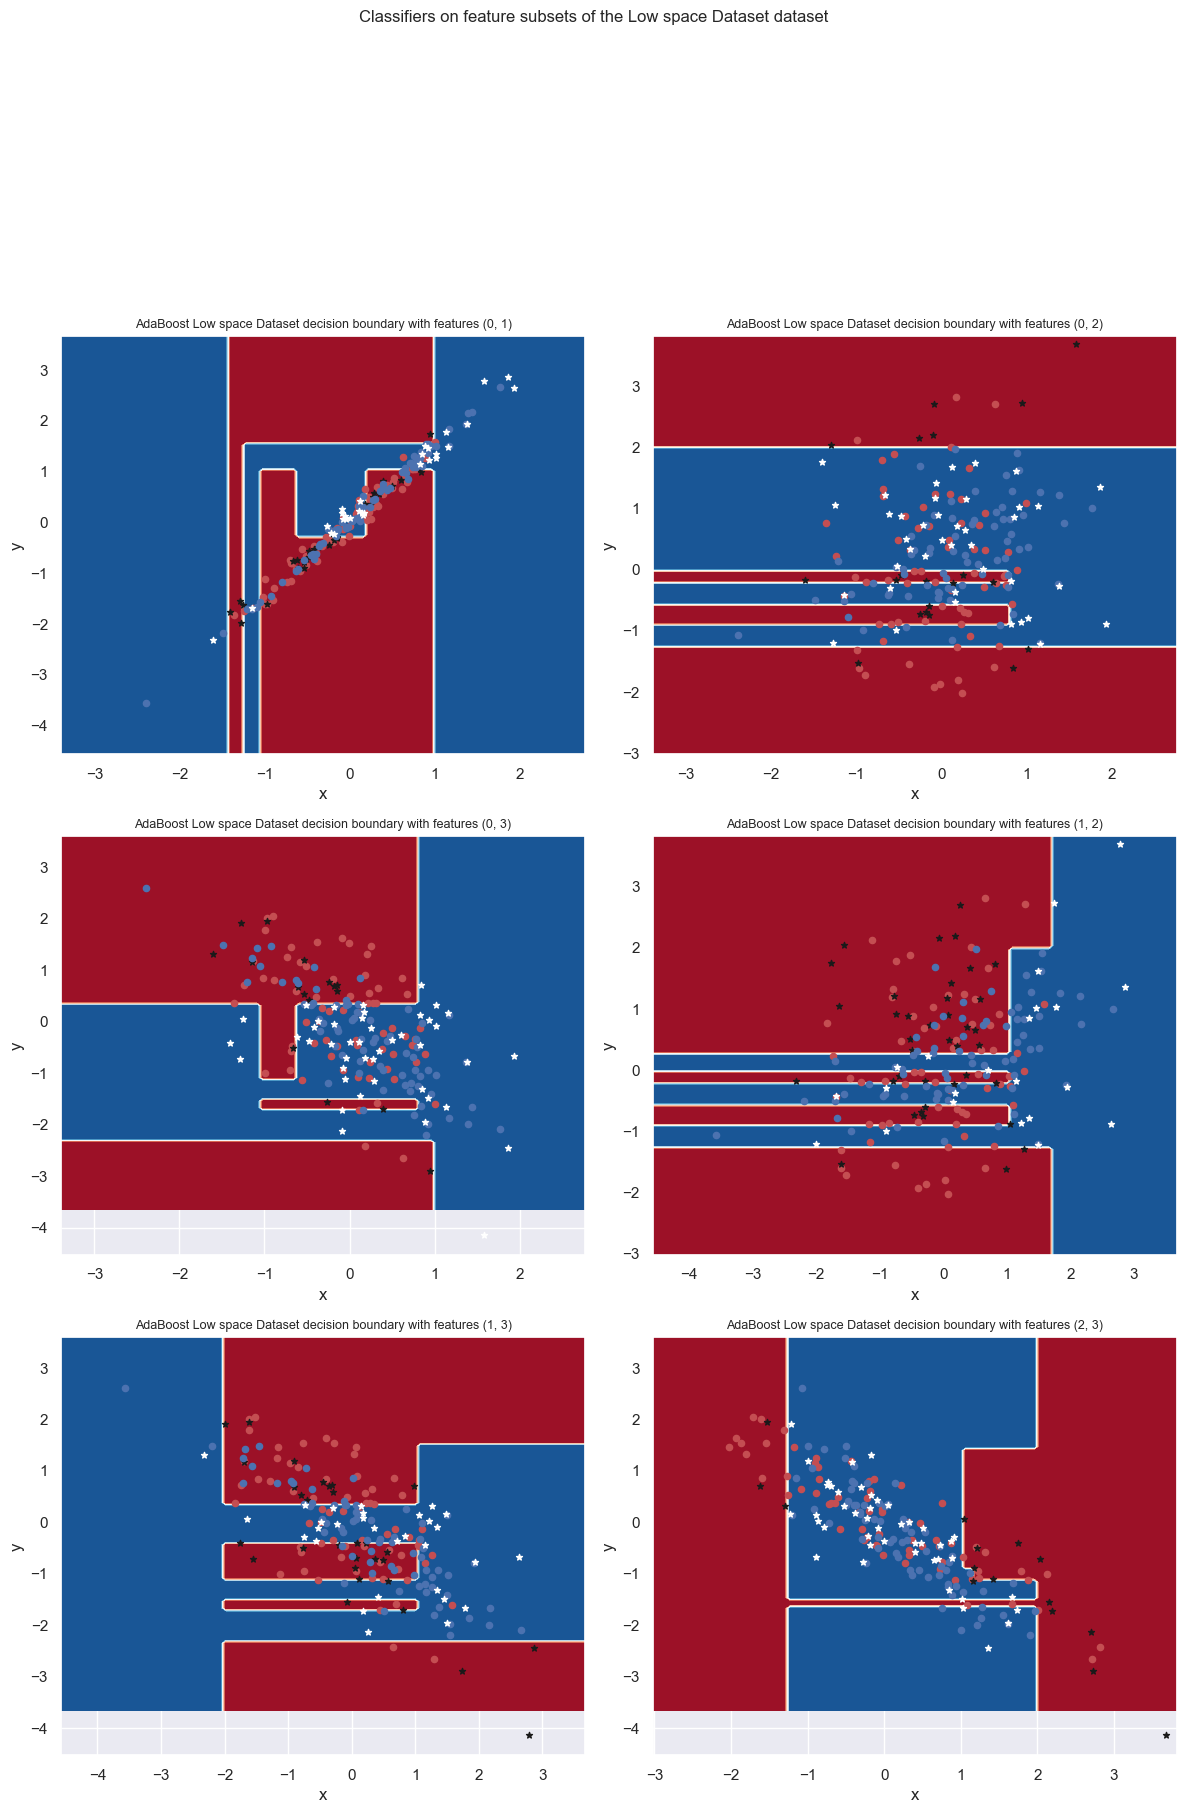

Accuracy of AdaBoostSklearn:
Train:0.7714285714285715
Test:0.7333333333333333


/Users/scohen6/projects/idc_msc/advanced-ml/exc1/venv/lib/python3.13/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


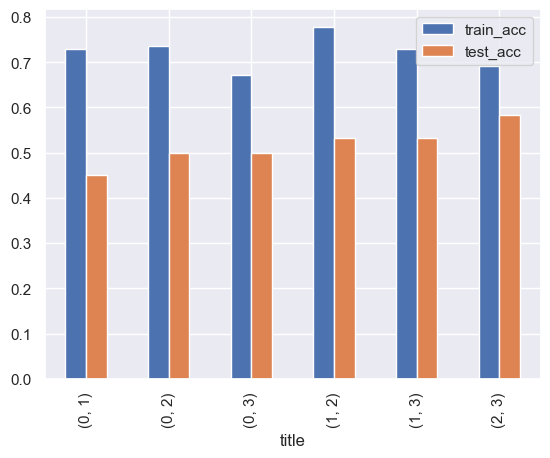

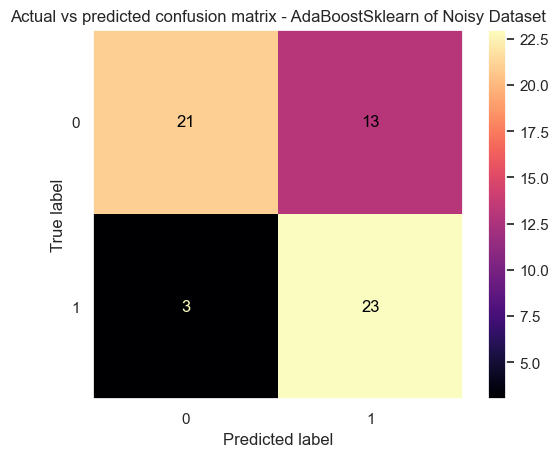

/Users/scohen6/projects/idc_msc/advanced-ml/exc1/venv/lib/python3.13/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/scohen6/projects/idc_msc/advanced-ml/exc1/venv/lib/python3.13/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/scohen6/projects/idc_msc/advanced-ml/exc1/venv/lib/python3.13/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/scohen6/projects/idc_msc/advanced-ml/exc1/venv/lib/python3.13/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning:

AdaBoost Noisy Dataset with 10 estimators with features (0, 1) has a score of
Train: 0.7785714285714286
Test: 0.7166666666666667
AdaBoost Noisy Dataset with 10 estimators with features (0, 2) has a score of
Train: 0.7857142857142857
Test: 0.7166666666666667
AdaBoost Noisy Dataset with 10 estimators with features (0, 3) has a score of
Train: 0.7857142857142857
Test: 0.7166666666666667
AdaBoost Noisy Dataset with 10 estimators with features (1, 2) has a score of
Train: 0.7857142857142857
Test: 0.7166666666666667
AdaBoost Noisy Dataset with 10 estimators with features (1, 3) has a score of
Train: 0.7857142857142857
Test: 0.7166666666666667
AdaBoost Noisy Dataset with 10 estimators with features (2, 3) has a score of
Train: 0.7357142857142858
Test: 0.6666666666666666


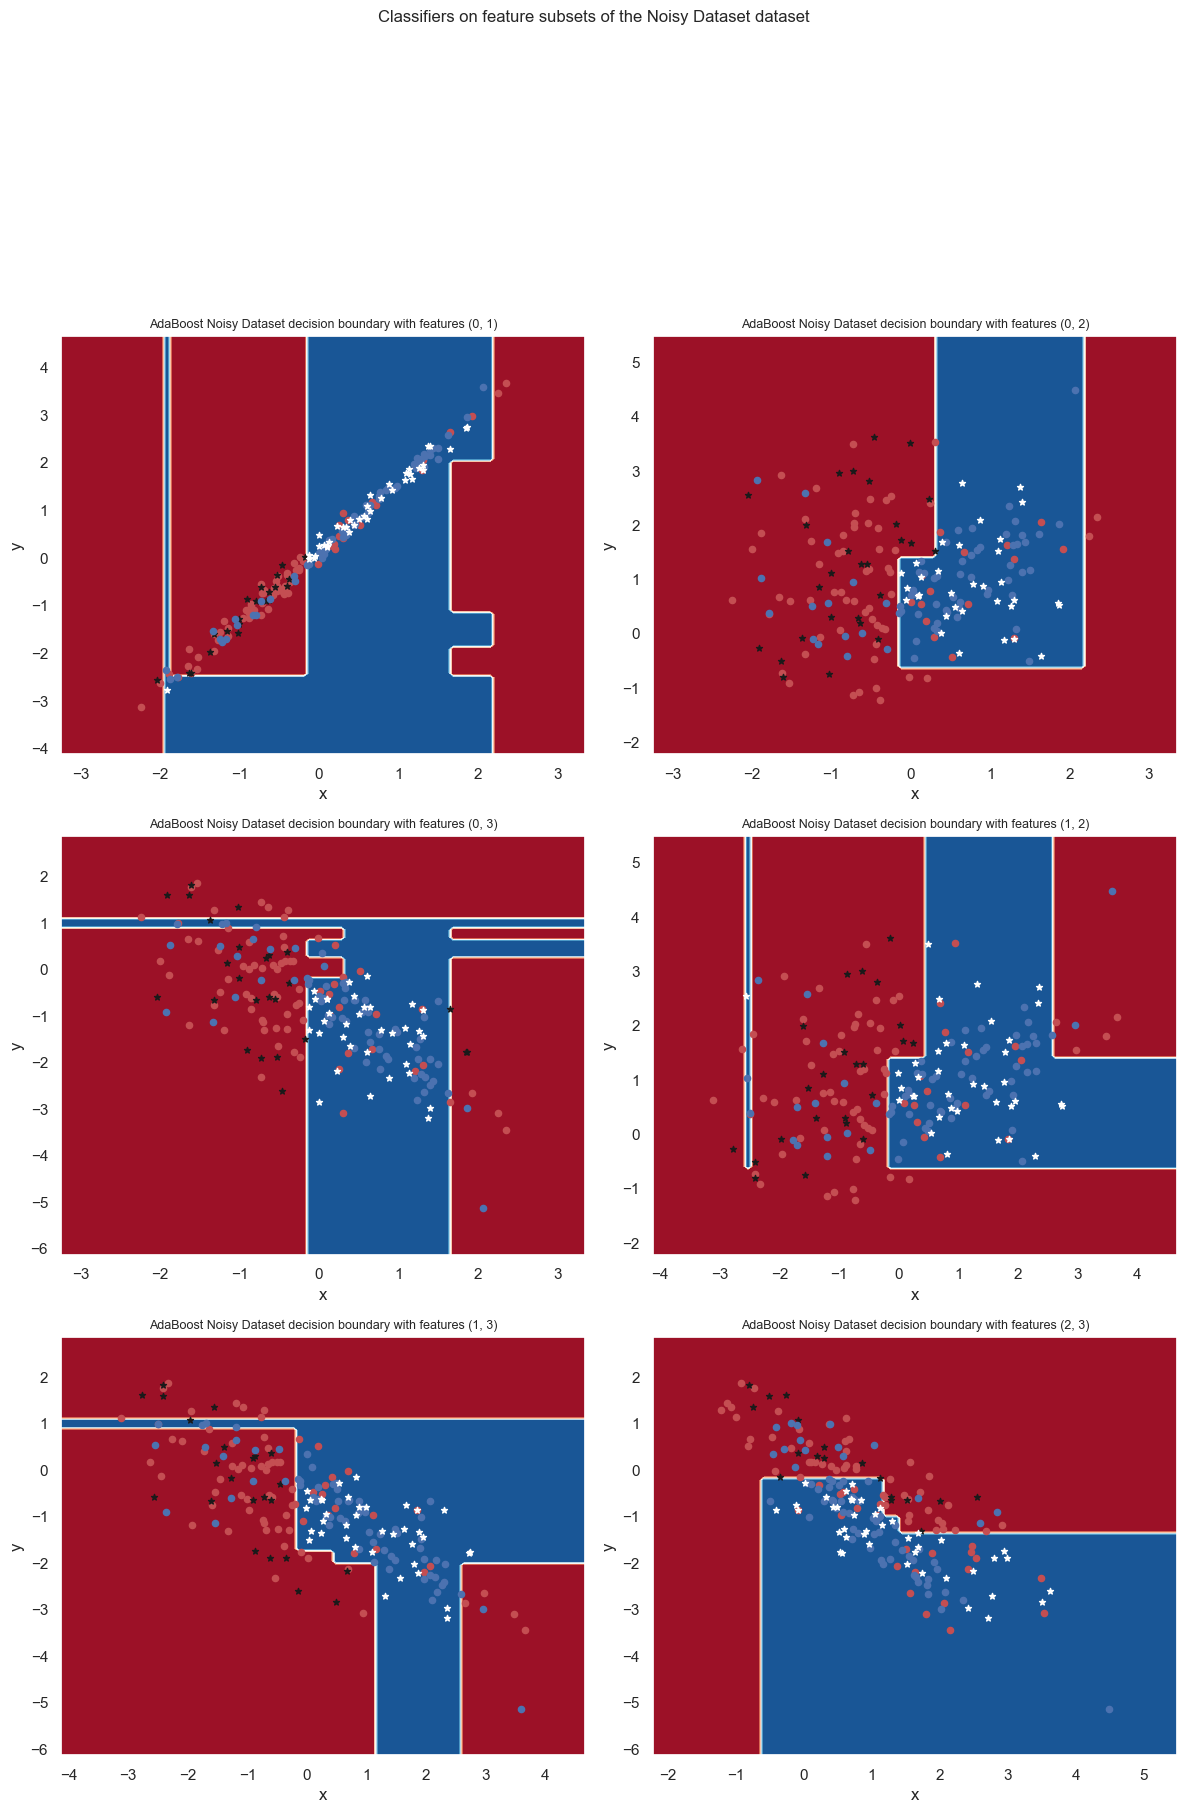

Accuracy of AdaBoostSklearn:
Train:0.6714285714285714
Test:0.5833333333333334


/Users/scohen6/projects/idc_msc/advanced-ml/exc1/venv/lib/python3.13/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


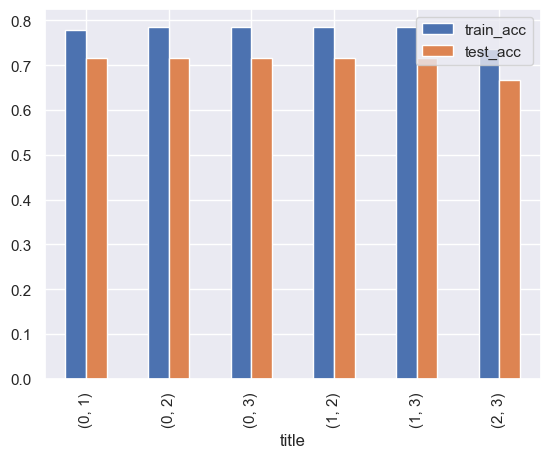

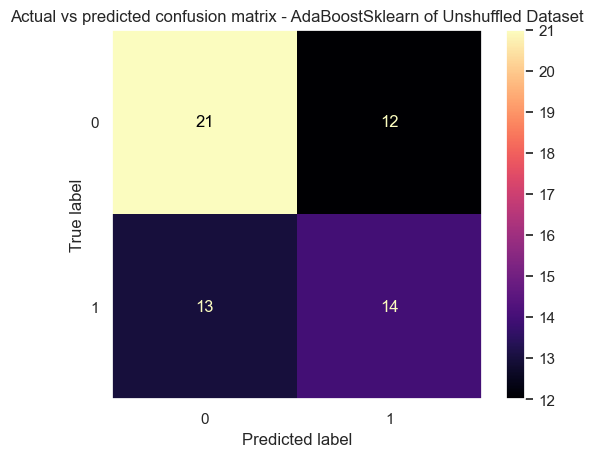

/Users/scohen6/projects/idc_msc/advanced-ml/exc1/venv/lib/python3.13/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/scohen6/projects/idc_msc/advanced-ml/exc1/venv/lib/python3.13/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/scohen6/projects/idc_msc/advanced-ml/exc1/venv/lib/python3.13/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoost Unshuffled Dataset with 10 estimators with features (0, 1) has a score of
Train: 0.7
Test: 0.5333333333333333
AdaBoost Unshuffled Dataset with 10 estimators with features (0, 2) has a score of
Train: 0.6928571428571428
Test: 0.55
AdaBoost Unshuffled Dataset with 10 estimators with features (0, 3) has a score of
Train: 0.6857142857142857
Test: 0.4666666666666667
AdaBoost Unshuffled Dataset with 10 estimators with features (1, 2) has a score of
Train: 0.6928571428571428
Test: 0.5666666666666667


/Users/scohen6/projects/idc_msc/advanced-ml/exc1/venv/lib/python3.13/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/scohen6/projects/idc_msc/advanced-ml/exc1/venv/lib/python3.13/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/scohen6/projects/idc_msc/advanced-ml/exc1/venv/lib/python3.13/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoost Unshuffled Dataset with 10 estimators with features (1, 3) has a score of
Train: 0.7
Test: 0.6
AdaBoost Unshuffled Dataset with 10 estimators with features (2, 3) has a score of
Train: 0.7214285714285714
Test: 0.48333333333333334


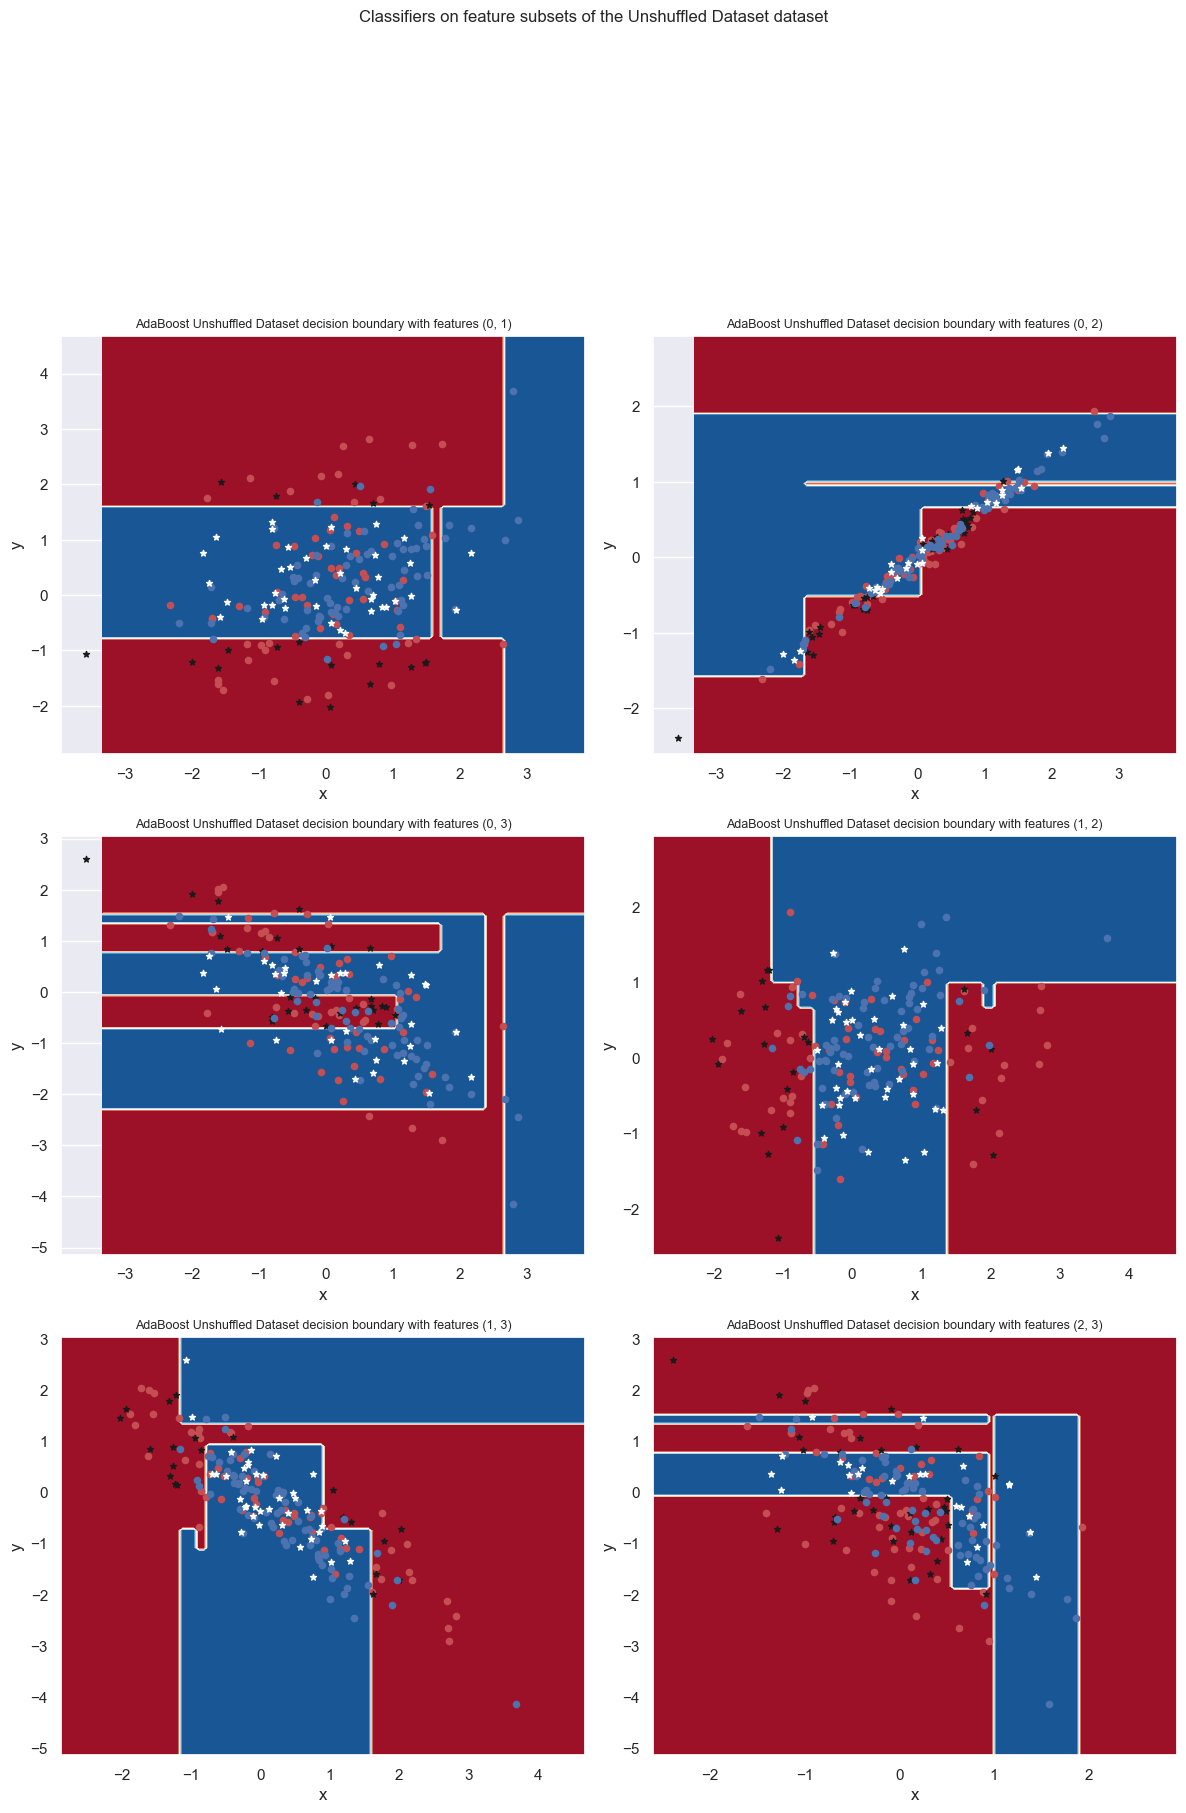

Accuracy of AdaBoostCustom:
Train:0.5642857142857143
Test:0.5666666666666667


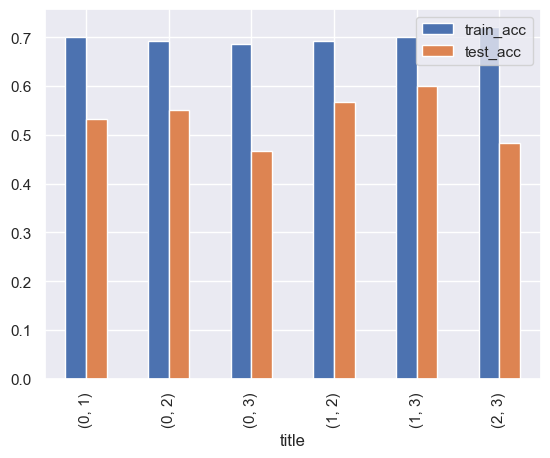

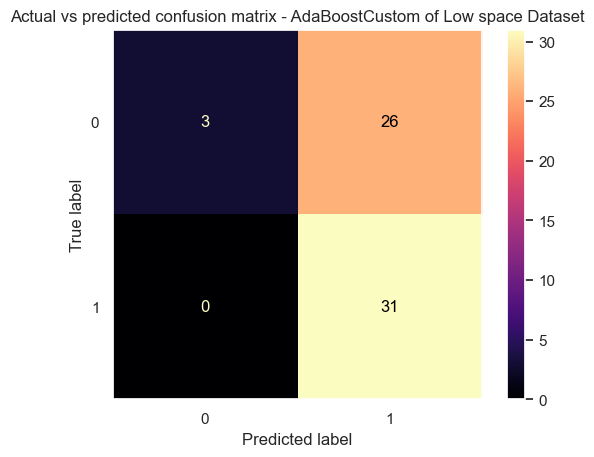

AdaB Low space Dataset with 10 estimators with features (0, 1) has a score of
Train: 0.6071428571428571
Test: 0.5666666666666667
AdaB Low space Dataset with 10 estimators with features (0, 2) has a score of
Train: 0.5642857142857143
Test: 0.5666666666666667
AdaB Low space Dataset with 10 estimators with features (0, 3) has a score of
Train: 0.5642857142857143
Test: 0.5666666666666667
AdaB Low space Dataset with 10 estimators with features (1, 2) has a score of
Train: 0.5642857142857143
Test: 0.5666666666666667
AdaB Low space Dataset with 10 estimators with features (1, 3) has a score of
Train: 0.5642857142857143
Test: 0.5666666666666667
AdaB Low space Dataset with 10 estimators with features (2, 3) has a score of
Train: 0.5642857142857143
Test: 0.5666666666666667


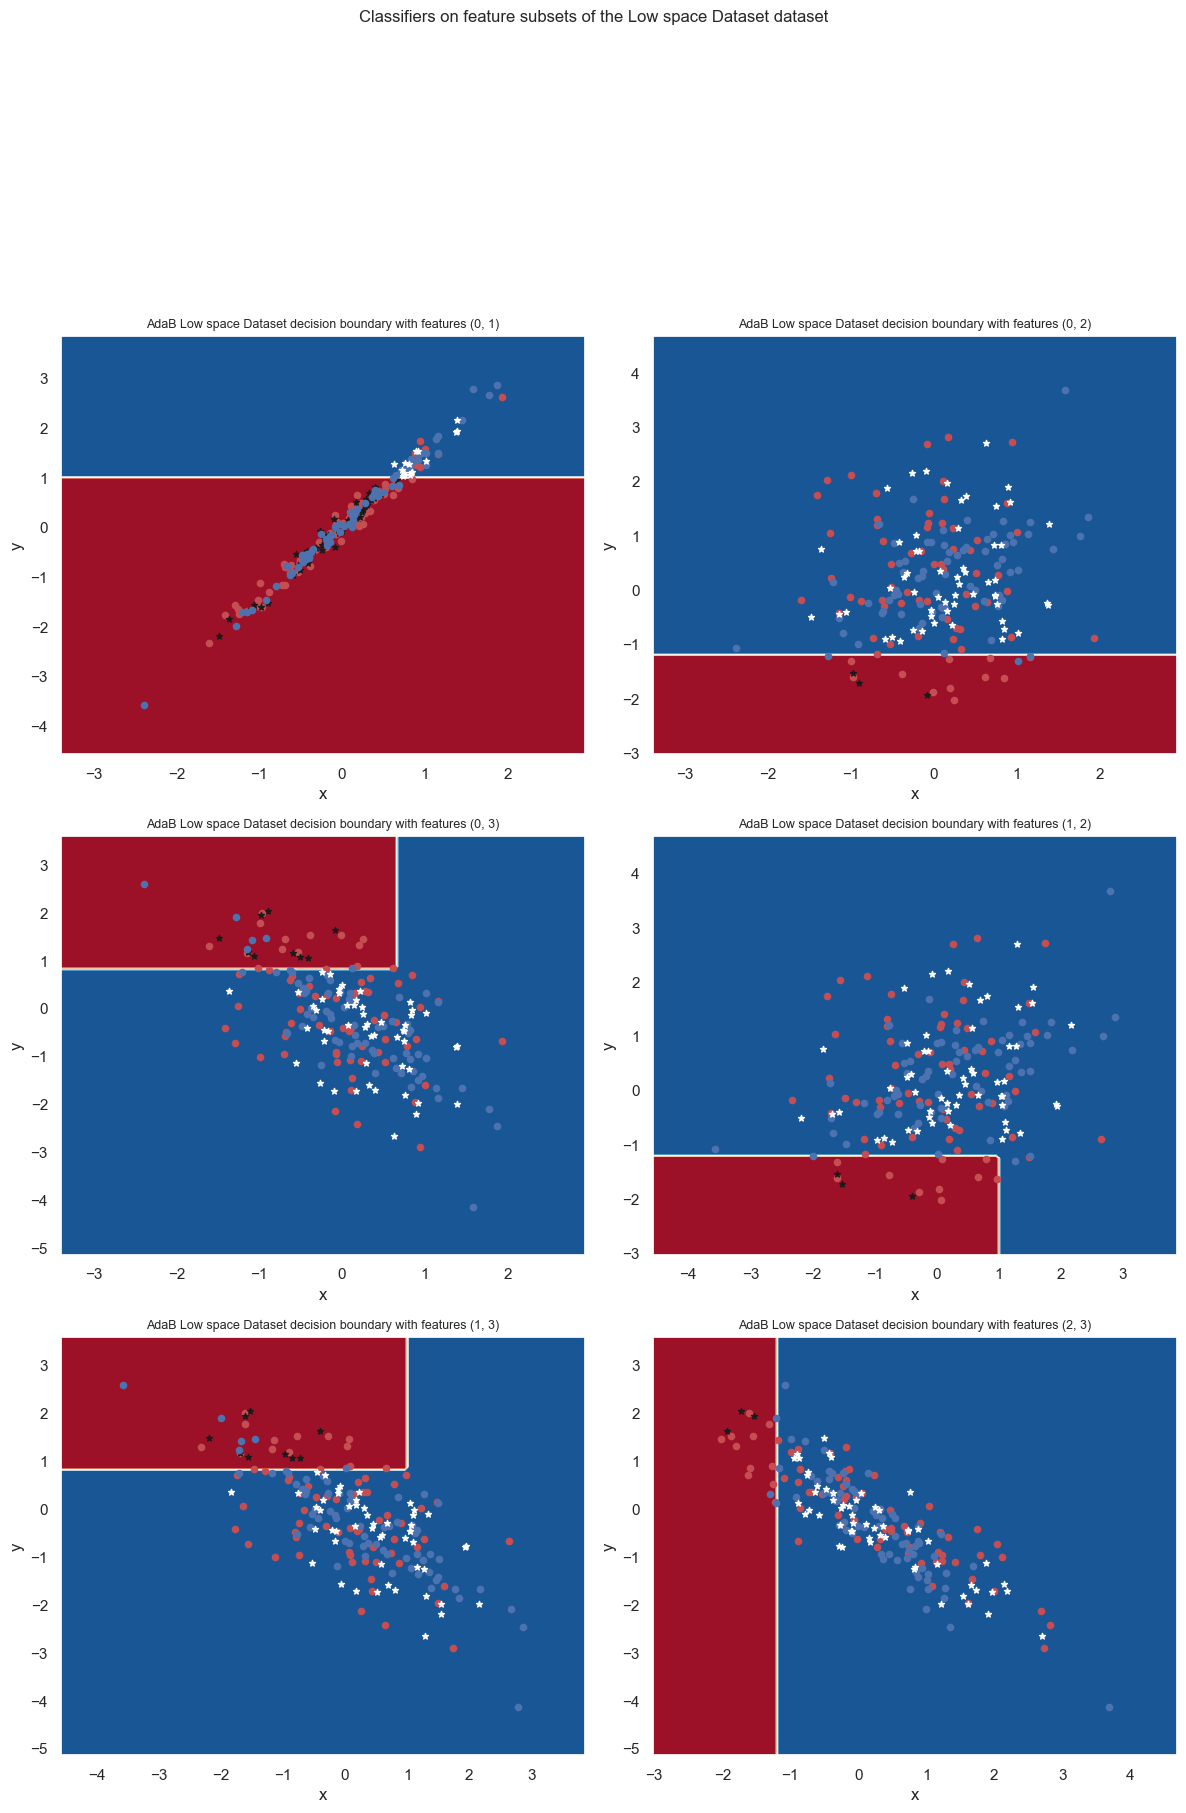

Accuracy of AdaBoostCustom:
Train:0.75
Test:0.7


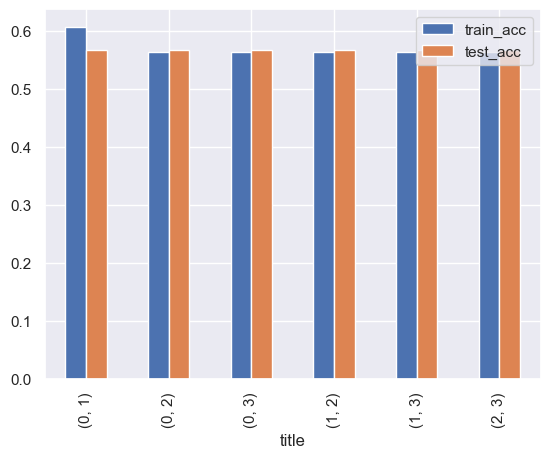

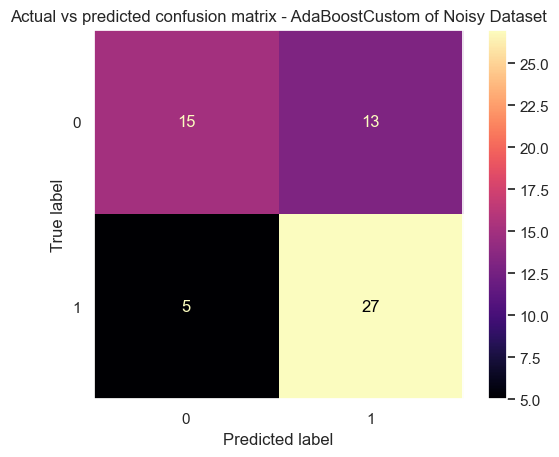

AdaB Noisy Dataset with 10 estimators with features (0, 1) has a score of
Train: 0.75
Test: 0.7
AdaB Noisy Dataset with 10 estimators with features (0, 2) has a score of
Train: 0.75
Test: 0.7
AdaB Noisy Dataset with 10 estimators with features (0, 3) has a score of
Train: 0.75
Test: 0.7
AdaB Noisy Dataset with 10 estimators with features (1, 2) has a score of
Train: 0.7285714285714285
Test: 0.7
AdaB Noisy Dataset with 10 estimators with features (1, 3) has a score of
Train: 0.7285714285714285
Test: 0.7
AdaB Noisy Dataset with 10 estimators with features (2, 3) has a score of
Train: 0.6142857142857143
Test: 0.5833333333333334


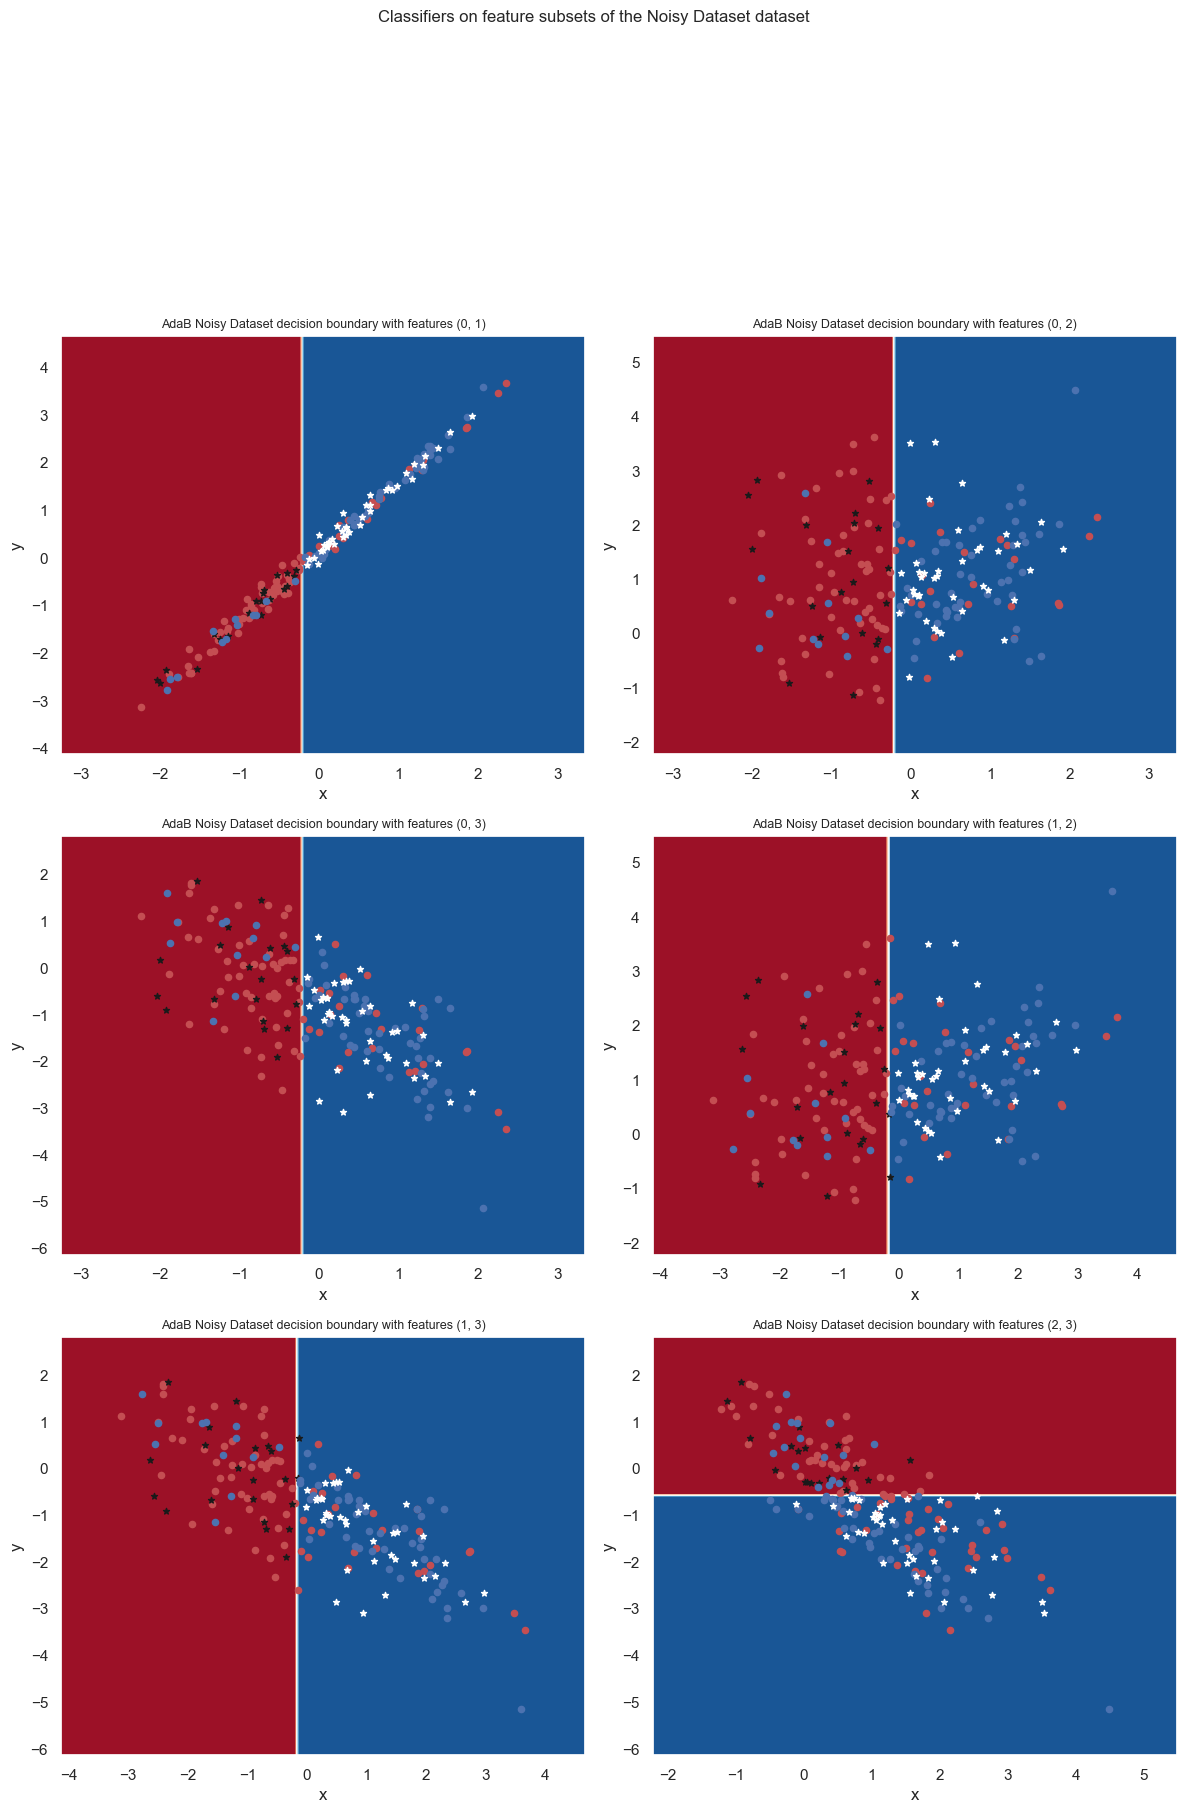

Accuracy of AdaBoostCustom:
Train:0.55
Test:0.6166666666666667


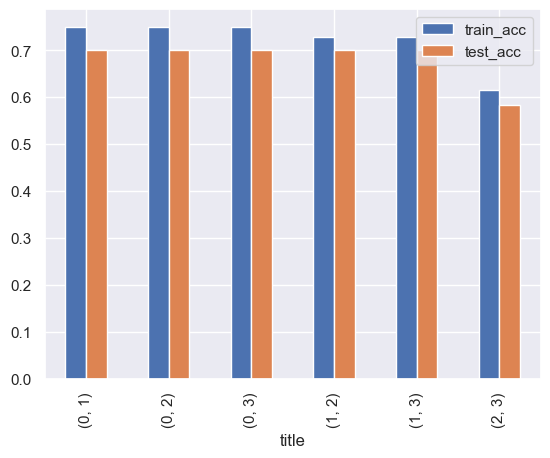

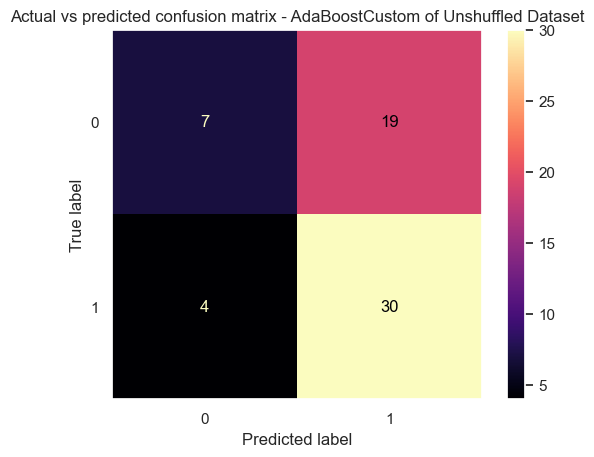

AdaB Unshuffled Dataset with 10 estimators with features (0, 1) has a score of
Train: 0.55
Test: 0.6166666666666667
AdaB Unshuffled Dataset with 10 estimators with features (0, 2) has a score of
Train: 0.6214285714285714
Test: 0.5333333333333333
AdaB Unshuffled Dataset with 10 estimators with features (0, 3) has a score of
Train: 0.6214285714285714
Test: 0.5333333333333333
AdaB Unshuffled Dataset with 10 estimators with features (1, 2) has a score of
Train: 0.5428571428571428
Test: 0.6166666666666667
AdaB Unshuffled Dataset with 10 estimators with features (1, 3) has a score of
Train: 0.5714285714285714
Test: 0.6
AdaB Unshuffled Dataset with 10 estimators with features (2, 3) has a score of
Train: 0.6214285714285714
Test: 0.5166666666666667


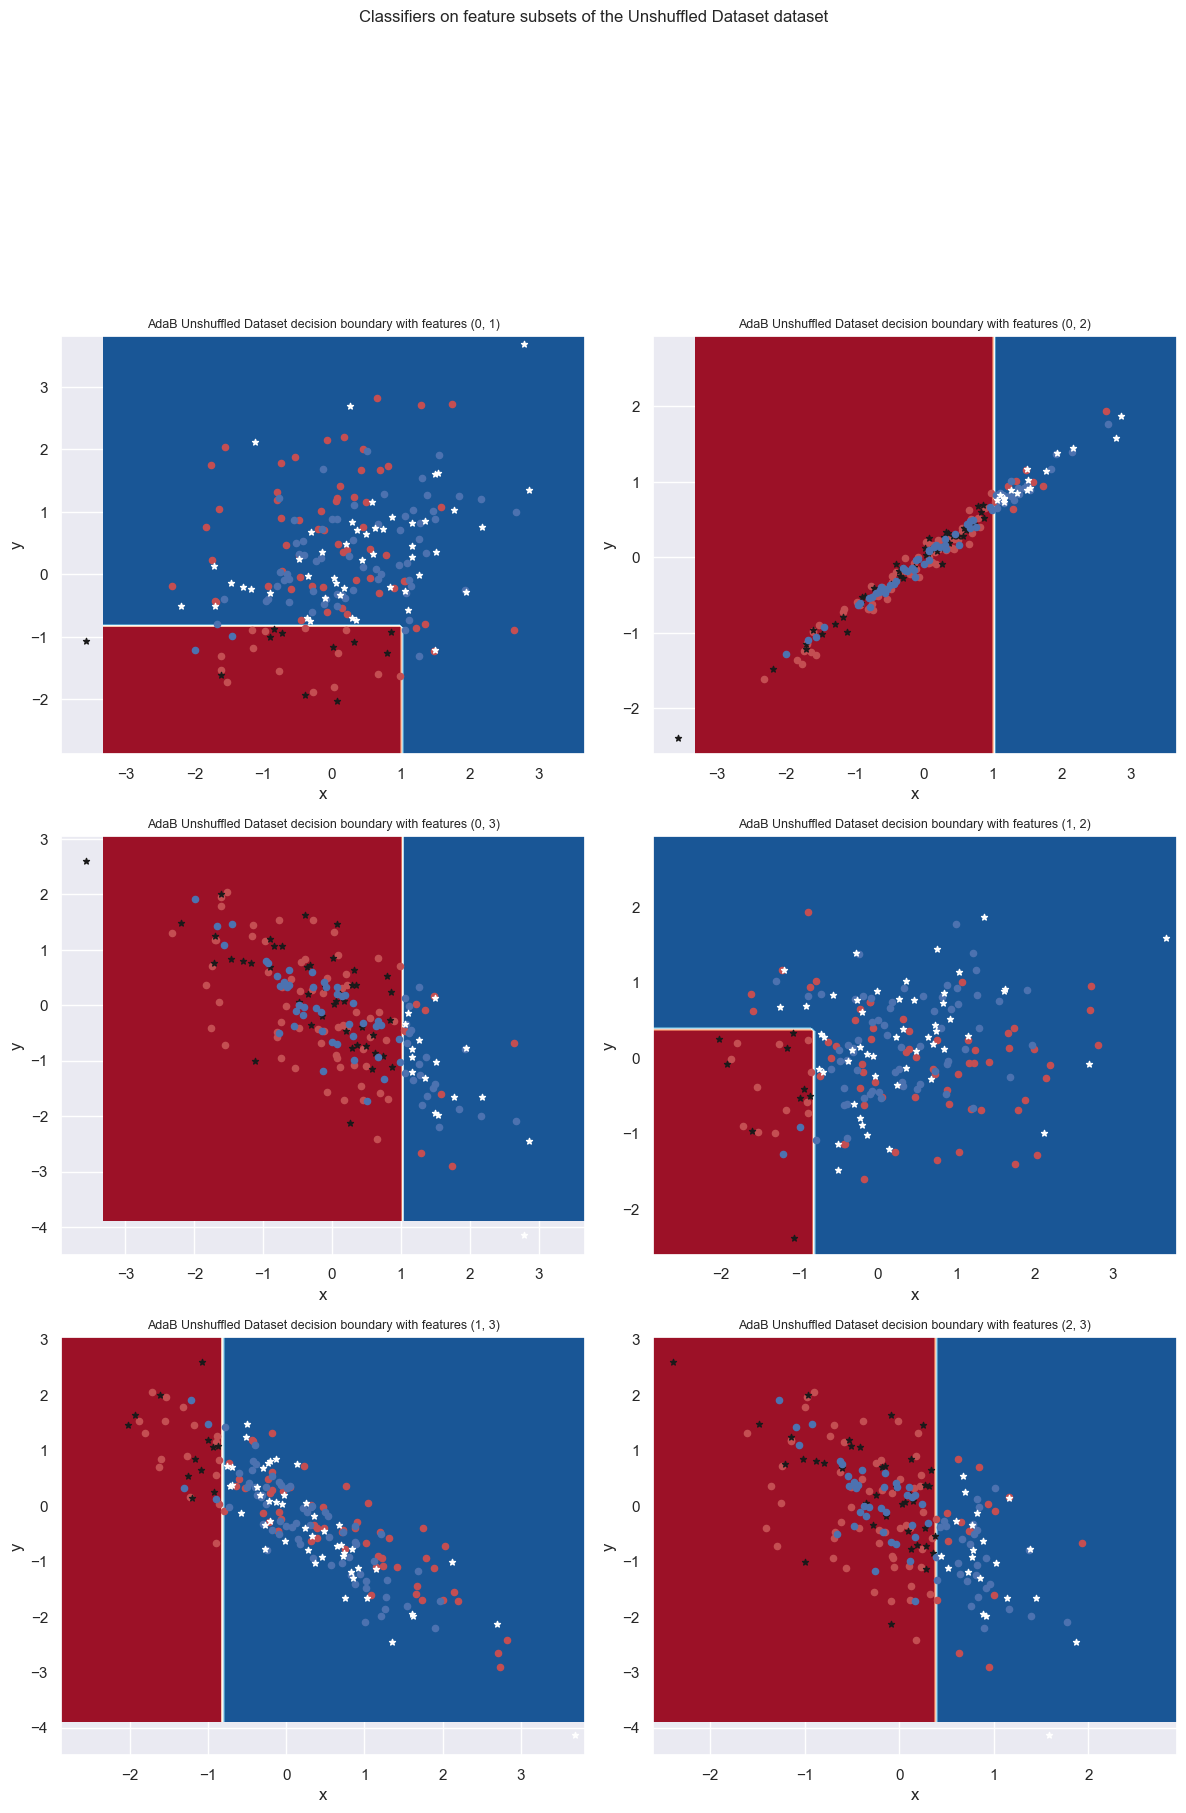

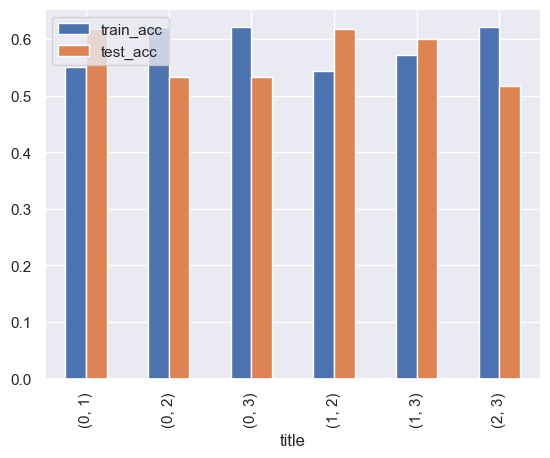

In [225]:
datasets = [{
    'n_samples': 200,
    'n_features': 4,
    'n_informative': 2,
    'n_classes': 2,
    'n_clusters_per_class': 1,
    'flip_y': 0.01, # Default flip value, no noise
    'class_sep': 0.2, # Reduces the space between label classes
    'title': "Low space Dataset"
},{
    'n_samples': 200,
    'n_features': 4,
    'n_informative': 2,
    'n_classes': 2,
    'n_clusters_per_class': 1,
    'flip_y': 0.3, # Makes a noisy dataset
    'class_sep': 1, # Default space seperation
    'title': "Noisy Dataset"
},{
    'n_samples': 200,
    'n_features': 4,
    'n_informative': 2,
    'n_classes': 2,
    'n_clusters_per_class': 1,
    'flip_y': 0.01, # Makes a noisy dataset
    'class_sep': 0.2, # Default space seperation
    'shuffle': False,
    'title': "Unshuffled Dataset"
}]

models = [
    AdaBoostClassifier(n_estimators=10, random_state=42),
    AdaBoostCustom(T=10, verbose=False)
]

for model in models:
    for dataset in datasets:
        X, y = make_classification(
            n_samples = dataset['n_samples'],
            n_features = dataset['n_features'],
            n_informative = dataset['n_informative'],
            n_classes = dataset['n_classes'],
            n_clusters_per_class = dataset['n_clusters_per_class'],
            flip_y = dataset['flip_y'],
            class_sep = dataset['class_sep'],
            shuffle = dataset['shuffle'] if 'shuffle' in dataset else True,
            random_state=42
        )
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # 70% training and 30% test
    
        # Train Adaboost Classifer
        res = model.fit(X_train, y_train)

        #Predict the response for test dataset
        y_train_pred = res.predict(X_train)
        y_pred = res.predict(X_test)
    
        model_title = type(model).__name__.replace("Classifier", "Sklearn")

        accuracies_list.append({
            "title": f"{model_title} of {dataset['title']}",
            "train_acc": accuracy_score(y_train, y_train_pred),
            "test_acc": accuracy_score(y_test, y_pred)
        })
        
        # Model Accuracy, how often is the classifier correct?
        print(f"Accuracy of {model_title}:\nTrain:{accuracy_score(y_train, y_train_pred)}\nTest:{accuracy_score(y_test, y_pred)}")
        
        matrix_plot = confusion_matrix(y_test, y_pred)
        cm_display = ConfusionMatrixDisplay(confusion_matrix=matrix_plot)
        cm_display.plot(cmap="magma")
        plt.title(
            f"Actual vs predicted confusion matrix - {model_title} of {dataset['title']}"
        )
        plt.grid(False)
        plt.show()
    
        print_plots(model, X_train, X_test, y_train, y_test, dataset['title'])

# Test algorithms
Test your AdaBoost, a library implementation of AdaBoost and at least two additional models, one of which must be another boosting algorithm on your two datasets.

Add plots and figures.

Please use the cell below to describe your suggested approach in detail. Use formal notations where appropriate.

Describe and discuss your results.

We chose two additional models to check our datasets:

1. Random Forest: We used a random forest with a max depth of 5 nodes per tree (h<=5) and with 200 estimators (tree)
   * Based on the following article: https://www.geeksforgeeks.org/random-forest-classifier-using-scikit-learn/
   * We found out that more than 3 levels of each tree tends to high overfitting and about 200 decision trees leads to better performance but they're still small enough do make the fitting in a short time
   * Regarding number of features, we kept the default level of "sqrt" which is actual of 2 features per tree (Since there is a total of 4 features per sample)
3. Gradient Boosting: We used a Gradient Boosting algorithm as another algorithm for comparison
   * We've got help from the following article https://www.datacamp.com/tutorial/guide-to-the-gradient-boosting-algorithm in order to fine tune the parameters to get a test performance similar to AdaBoost
   * The most challenging part for this model is to prevent overfitting. We found out the train accuracy is almost perfect but the test accuracy is much much lower. In order to prevent overfitting as much as we can, we've configured the following hypherparameters:
   * 100 estimators. We found out that 100 trees are enough for high performance with 2 features per tree (root square of 4)
   * Max depth of 3 levels. We found out that more levels tends to high overfitting and low test performance
   * Learning rate: This is the most important hyper parameter. This hyper parameter is responsible for shrinking each weak learner, while the default one is 0.1. We found out that we must reduce the learning rate in order to shrink the weak learners more than default. We found that a learning rate of 0.05 is enough for our desired performance
  
* Based on the following article https://www.geeksforgeeks.org/gradient-boosting-vs-random-forest/ and our experiments, we can tell that Gradient Boosting tends to overfitting much more than Random Forest, and we indeed needed to tune the hyper parameters many time in order to get better test performance
* In addition, altogh usually Gradiant Boosting tends to better performance than Random Forest, here it's not the use-case since Gradient Boosting is much sensitive for a noisy dataset, and in the following examples, the dataset is not such clean. Therefore, the random forest algorithm found as more useful for the generated datasets which not clean enough

Accuracy of RandomForest:
Train:0.7571428571428571
Test:0.6333333333333333


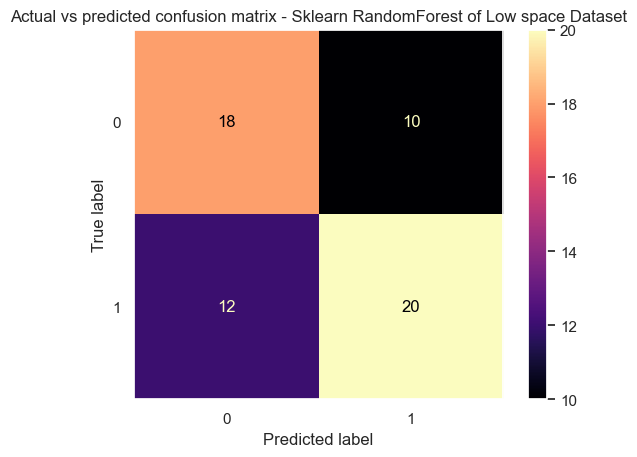

RandomForest Low space Dataset with 200 estimators with features (0, 1) has a score of
Train: 0.7642857142857142
Test: 0.48333333333333334
RandomForest Low space Dataset with 200 estimators with features (0, 2) has a score of
Train: 0.75
Test: 0.6166666666666667
RandomForest Low space Dataset with 200 estimators with features (0, 3) has a score of
Train: 0.7357142857142858
Test: 0.5833333333333334
RandomForest Low space Dataset with 200 estimators with features (1, 2) has a score of
Train: 0.7357142857142858
Test: 0.6
RandomForest Low space Dataset with 200 estimators with features (1, 3) has a score of
Train: 0.7642857142857142
Test: 0.5666666666666667
RandomForest Low space Dataset with 200 estimators with features (2, 3) has a score of
Train: 0.75
Test: 0.55


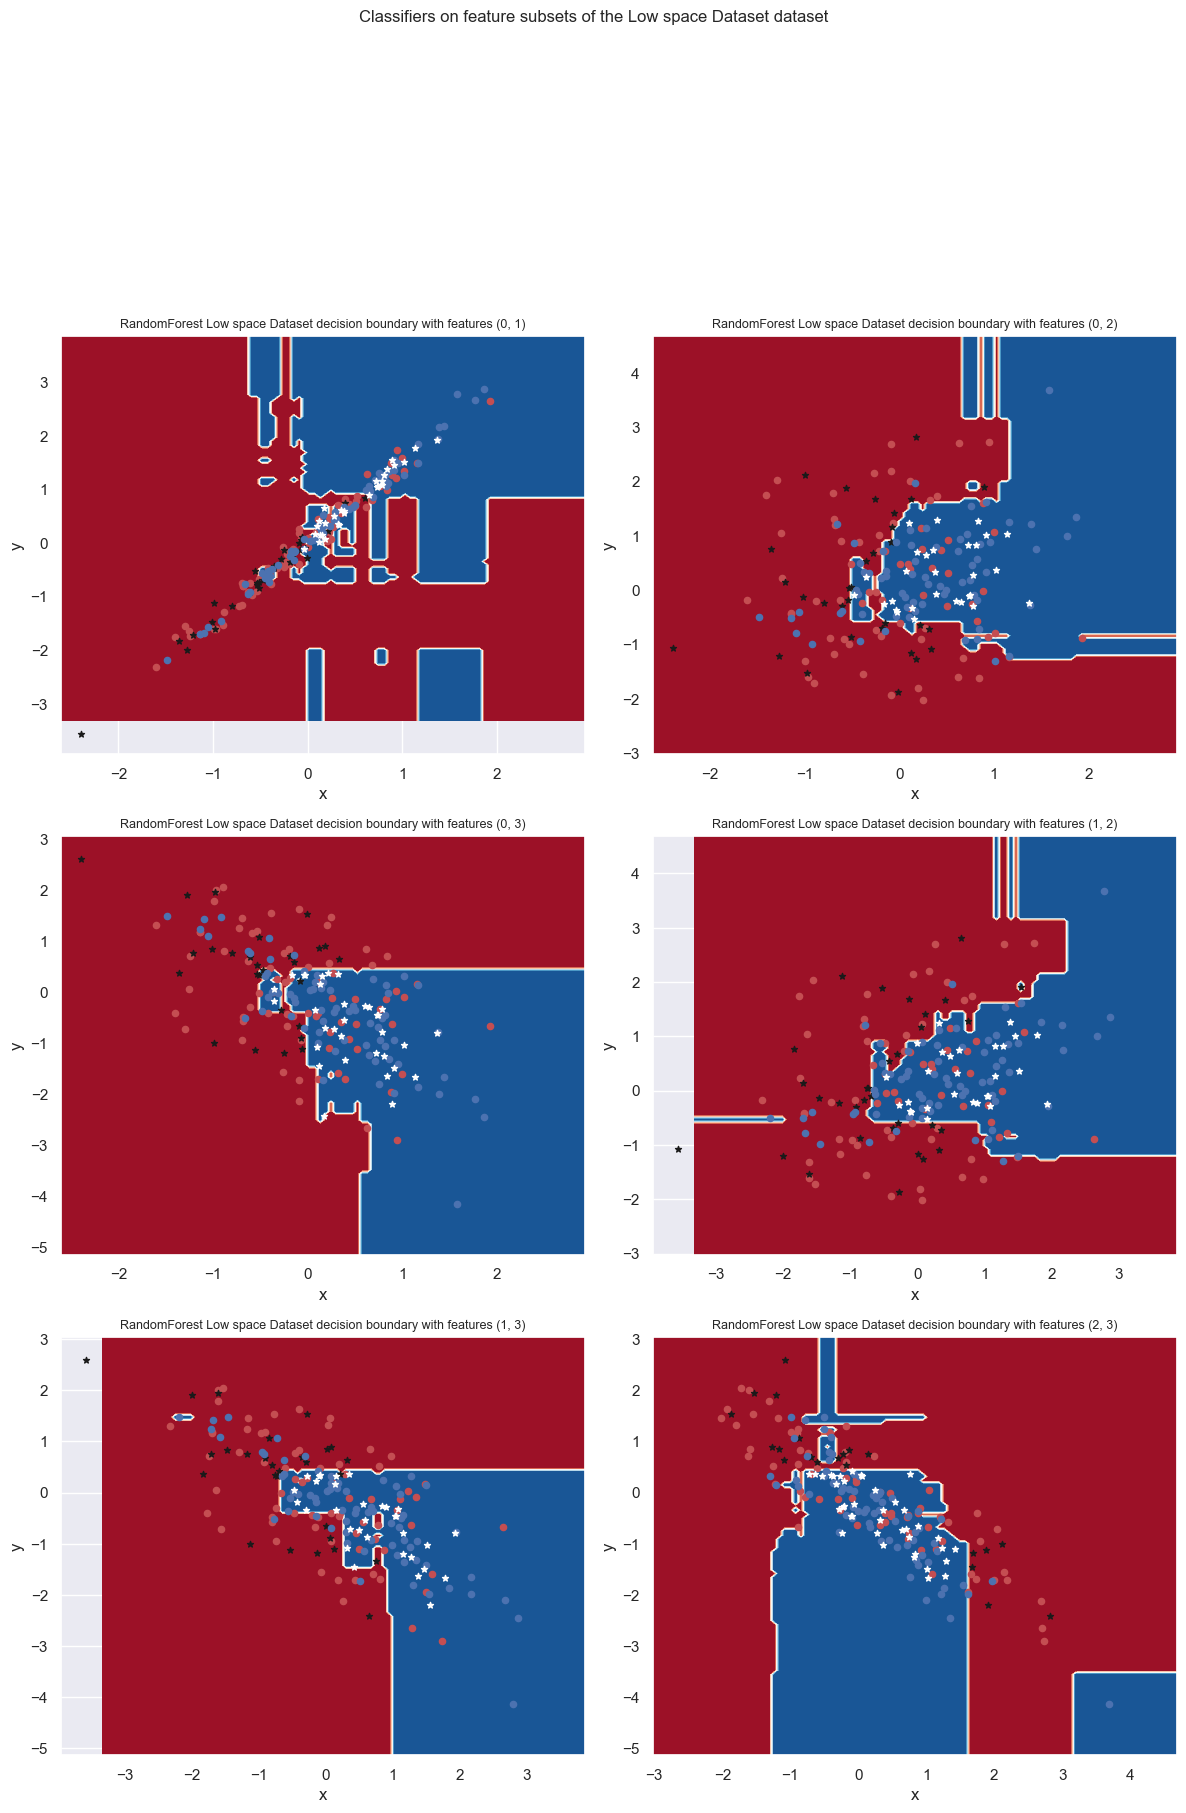

Accuracy of RandomForest:
Train:0.8
Test:0.6666666666666666


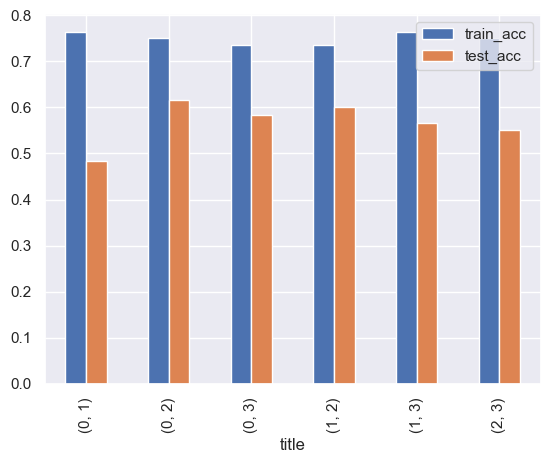

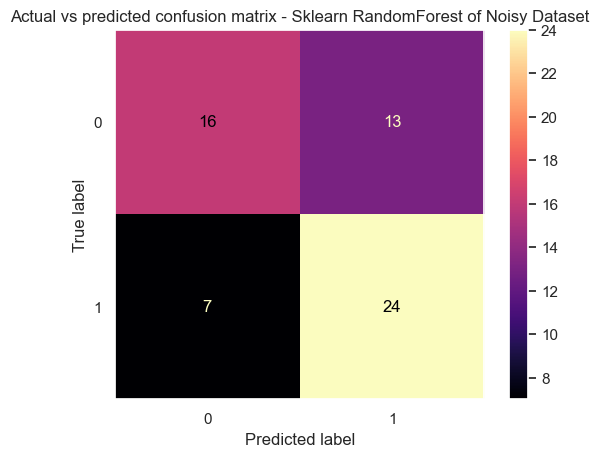

RandomForest Noisy Dataset with 200 estimators with features (0, 1) has a score of
Train: 0.8
Test: 0.65
RandomForest Noisy Dataset with 200 estimators with features (0, 2) has a score of
Train: 0.7928571428571428
Test: 0.65
RandomForest Noisy Dataset with 200 estimators with features (0, 3) has a score of
Train: 0.8
Test: 0.6833333333333333
RandomForest Noisy Dataset with 200 estimators with features (1, 2) has a score of
Train: 0.7928571428571428
Test: 0.6333333333333333
RandomForest Noisy Dataset with 200 estimators with features (1, 3) has a score of
Train: 0.7928571428571428
Test: 0.6833333333333333
RandomForest Noisy Dataset with 200 estimators with features (2, 3) has a score of
Train: 0.8
Test: 0.65


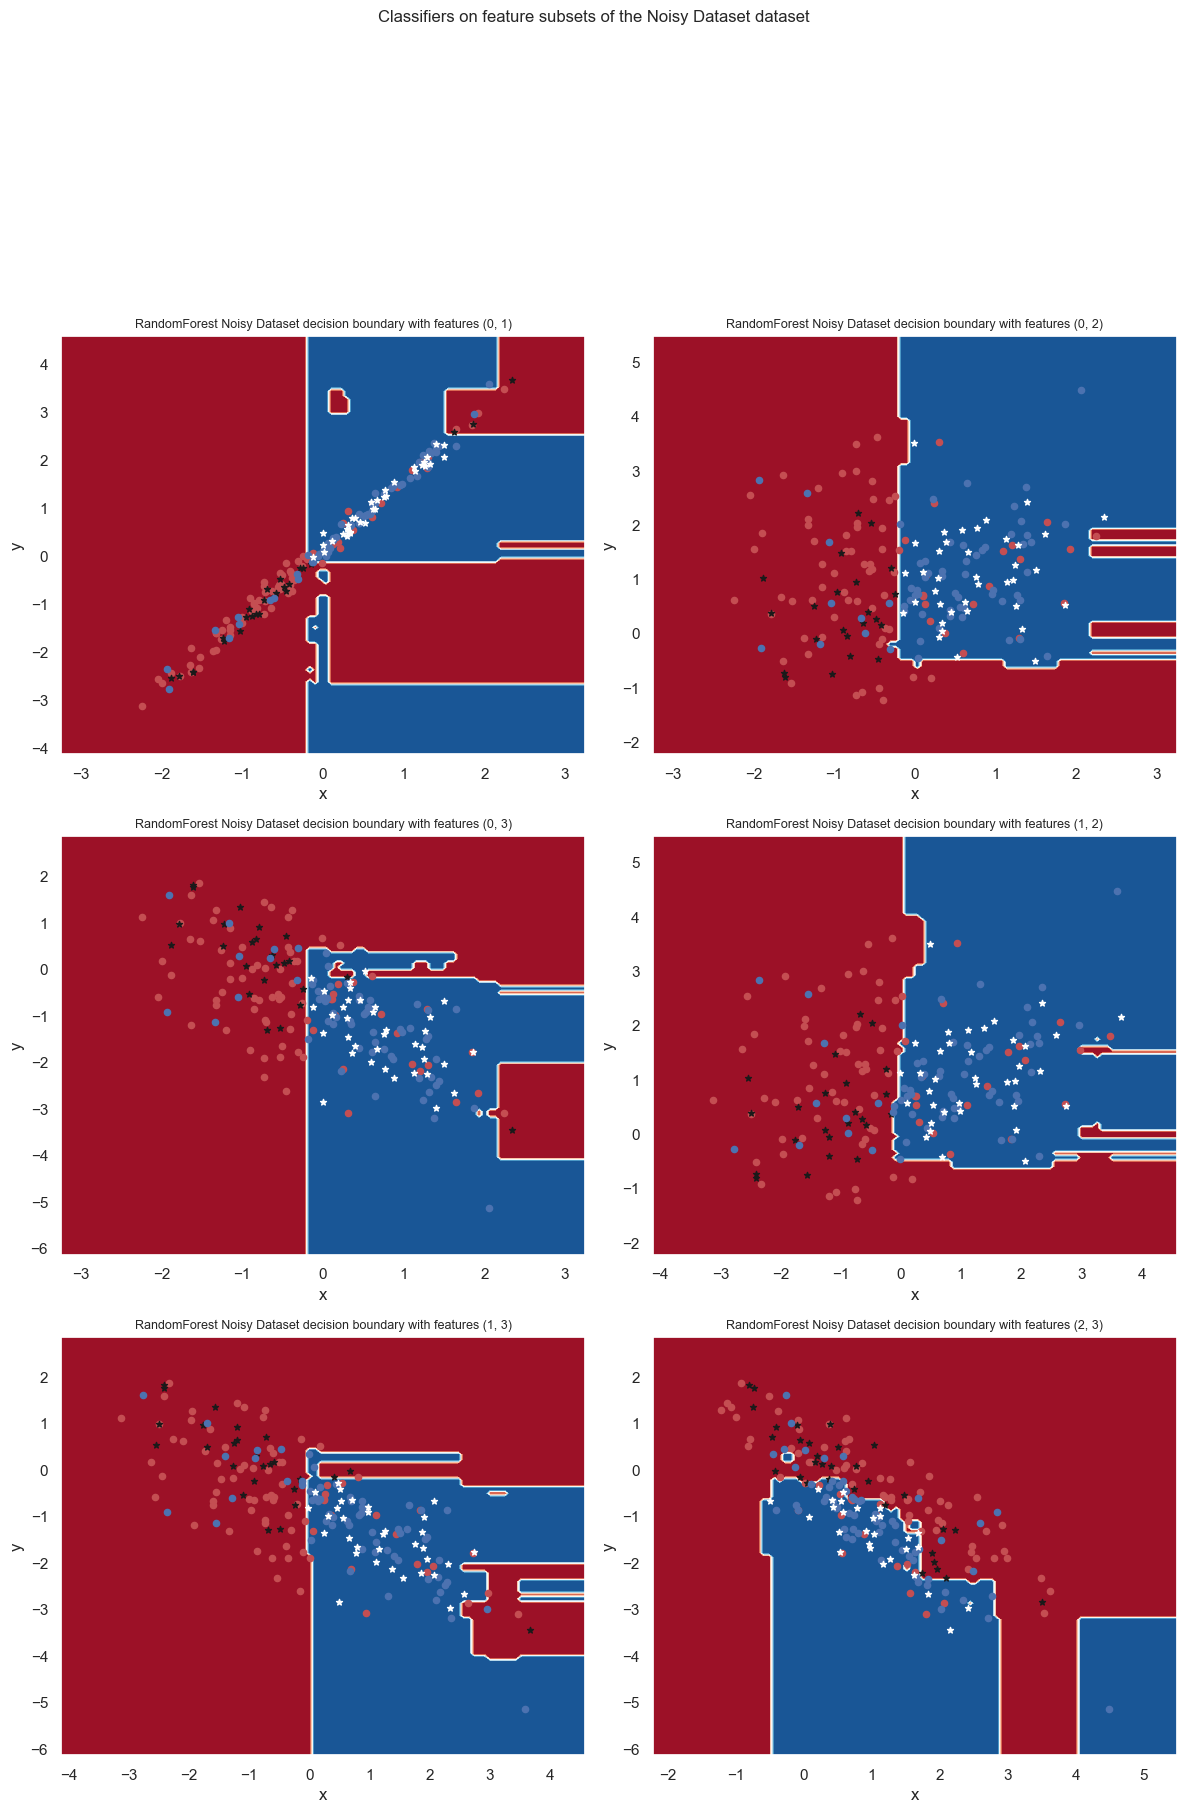

Accuracy of RandomForest:
Train:0.7928571428571428
Test:0.5833333333333334


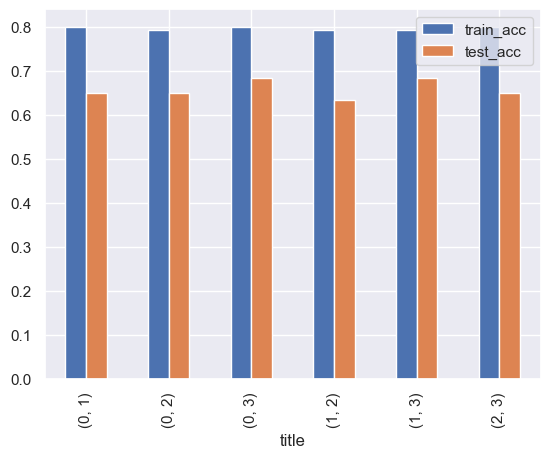

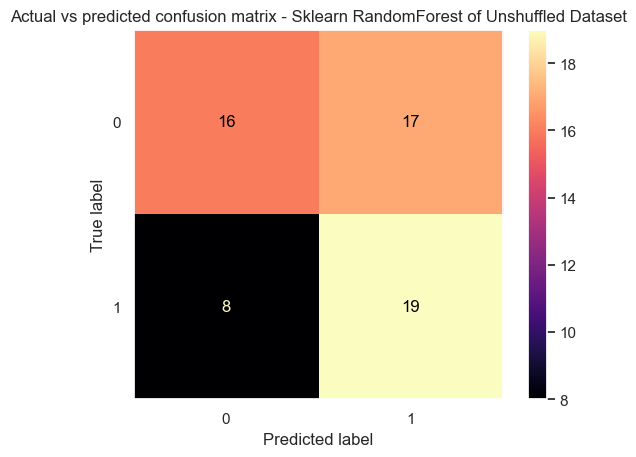

RandomForest Unshuffled Dataset with 200 estimators with features (0, 1) has a score of
Train: 0.8142857142857143
Test: 0.5666666666666667
RandomForest Unshuffled Dataset with 200 estimators with features (0, 2) has a score of
Train: 0.7357142857142858
Test: 0.5
RandomForest Unshuffled Dataset with 200 estimators with features (0, 3) has a score of
Train: 0.7714285714285715
Test: 0.5333333333333333
RandomForest Unshuffled Dataset with 200 estimators with features (1, 2) has a score of
Train: 0.7857142857142857
Test: 0.5833333333333334
RandomForest Unshuffled Dataset with 200 estimators with features (1, 3) has a score of
Train: 0.7785714285714286
Test: 0.5333333333333333
RandomForest Unshuffled Dataset with 200 estimators with features (2, 3) has a score of
Train: 0.7785714285714286
Test: 0.6


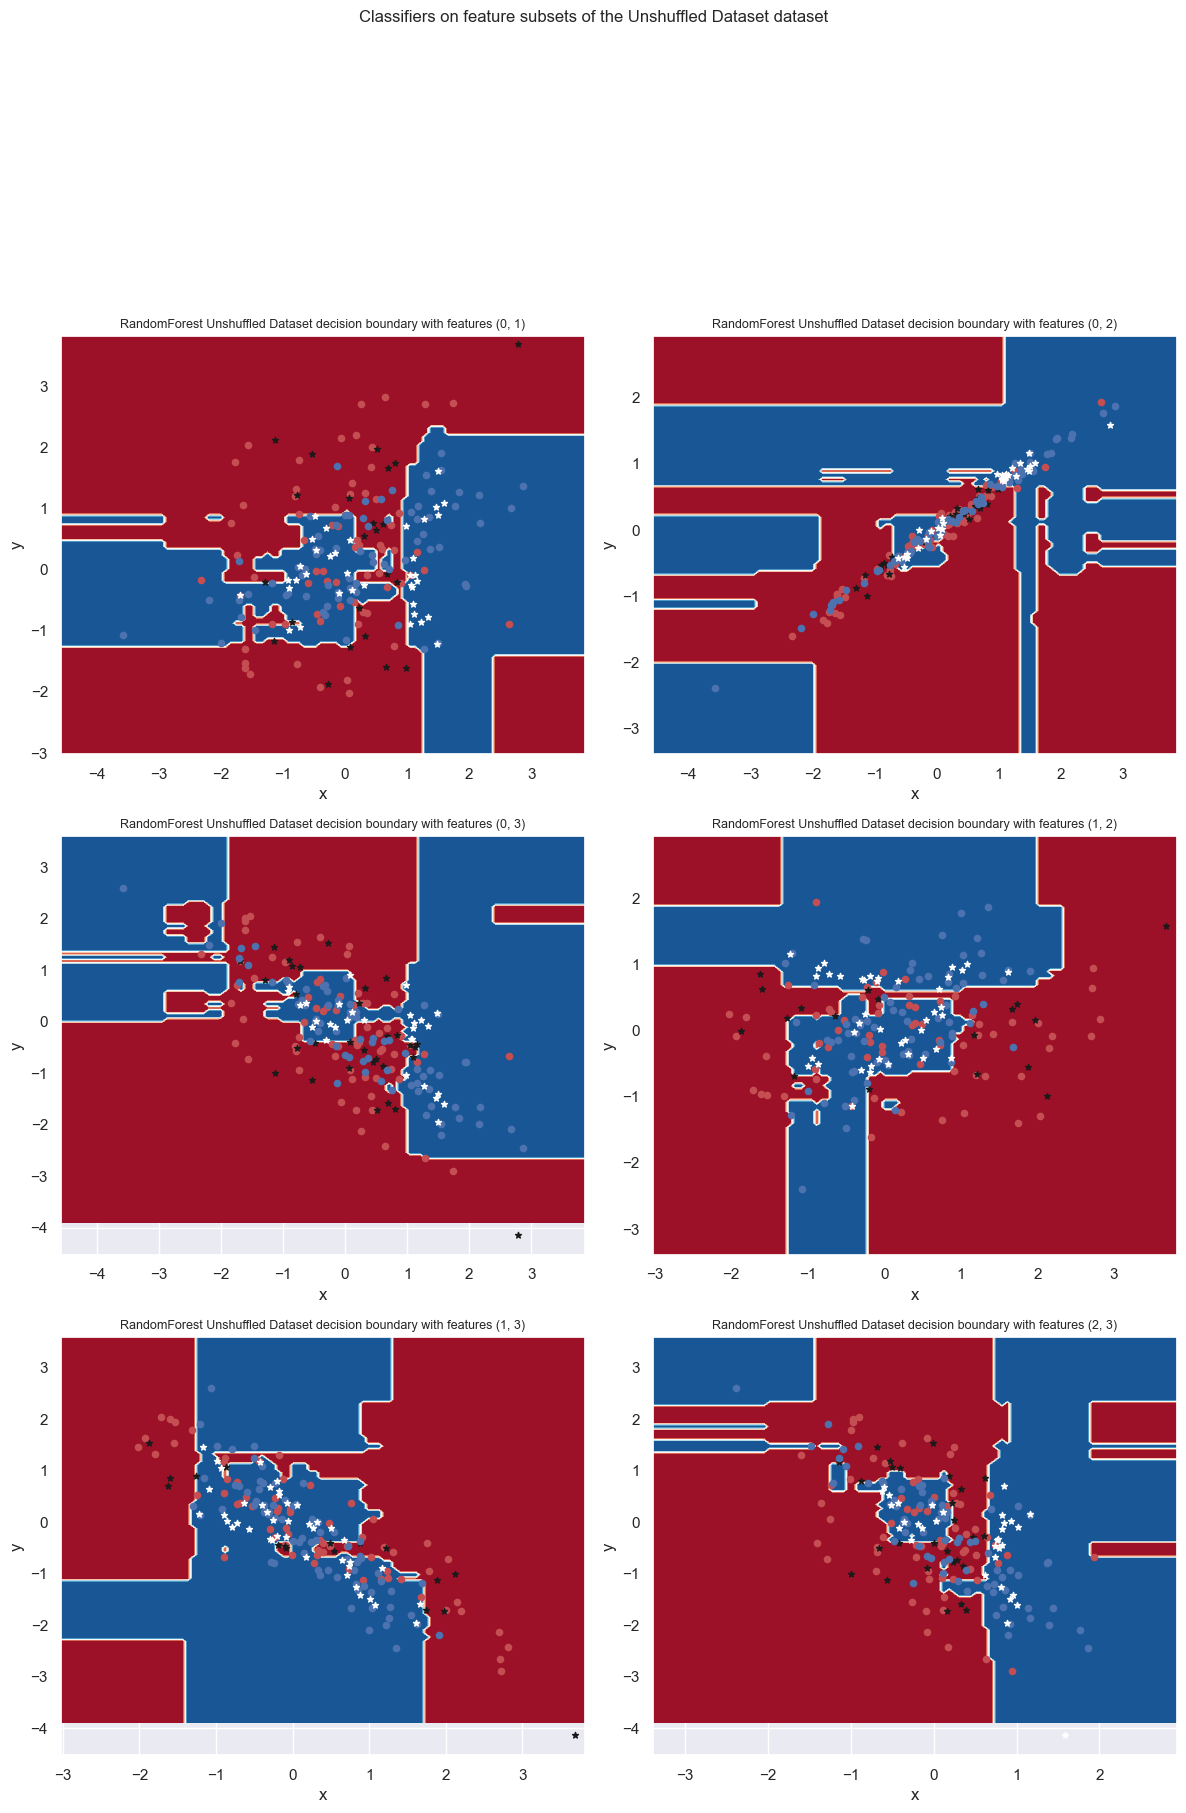

Accuracy of GradientBoosting:
Train:0.9714285714285714
Test:0.5166666666666667


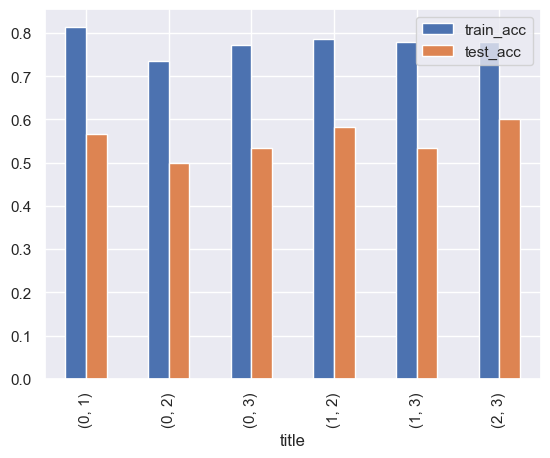

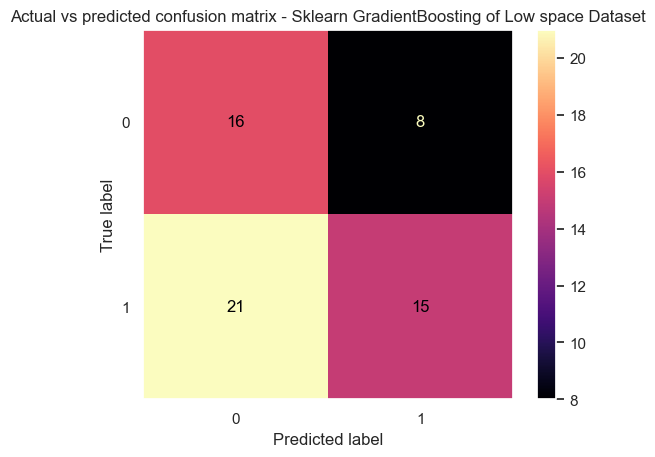

GradientBoosting Low space Dataset with 100 estimators with features (0, 1) has a score of
Train: 0.9357142857142857
Test: 0.4666666666666667
GradientBoosting Low space Dataset with 100 estimators with features (0, 2) has a score of
Train: 0.9214285714285714
Test: 0.6166666666666667
GradientBoosting Low space Dataset with 100 estimators with features (0, 3) has a score of
Train: 0.9214285714285714
Test: 0.5
GradientBoosting Low space Dataset with 100 estimators with features (1, 2) has a score of
Train: 0.95
Test: 0.5666666666666667
GradientBoosting Low space Dataset with 100 estimators with features (1, 3) has a score of
Train: 0.9571428571428572
Test: 0.48333333333333334
GradientBoosting Low space Dataset with 100 estimators with features (2, 3) has a score of
Train: 0.9357142857142857
Test: 0.6333333333333333


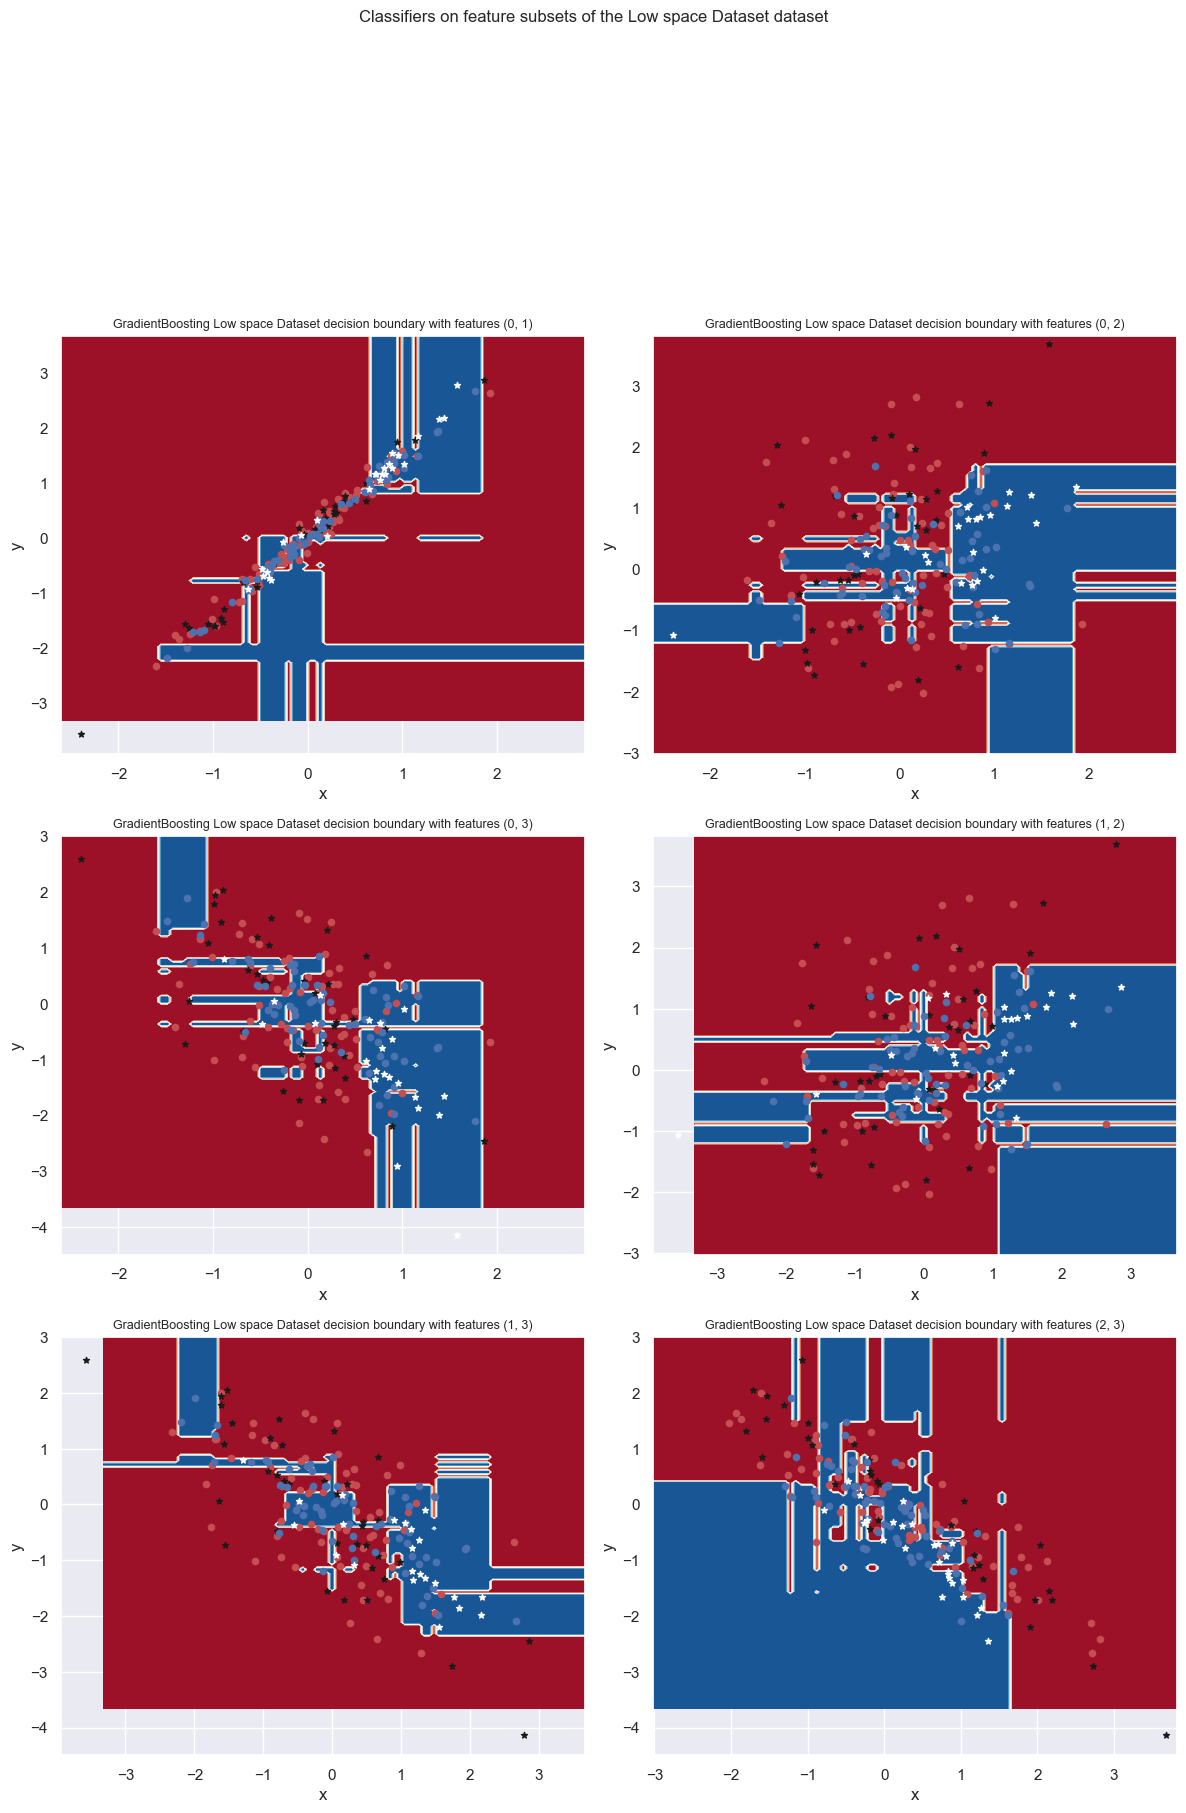

Accuracy of GradientBoosting:
Train:0.9571428571428572
Test:0.7


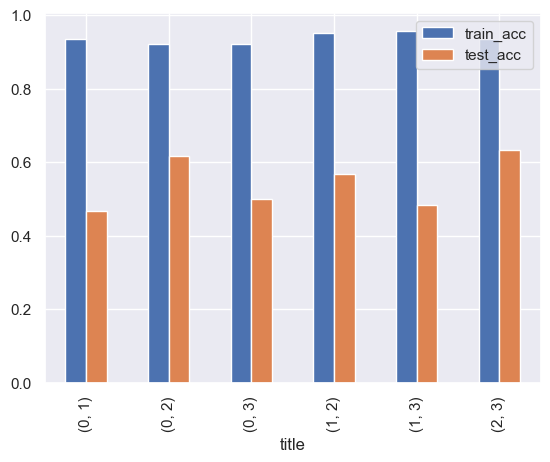

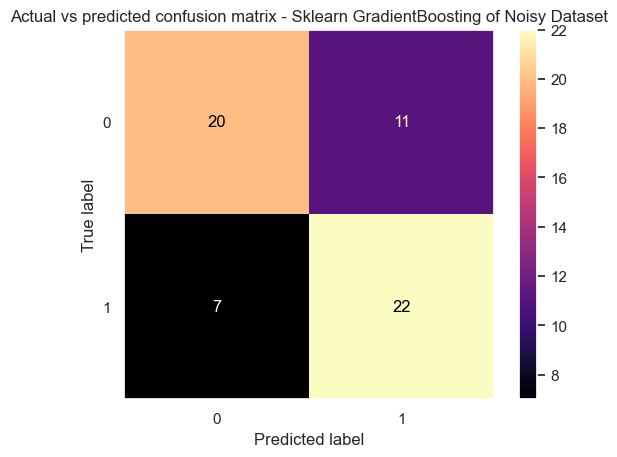

GradientBoosting Noisy Dataset with 100 estimators with features (0, 1) has a score of
Train: 0.9214285714285714
Test: 0.7
GradientBoosting Noisy Dataset with 100 estimators with features (0, 2) has a score of
Train: 0.9357142857142857
Test: 0.6833333333333333
GradientBoosting Noisy Dataset with 100 estimators with features (0, 3) has a score of
Train: 0.95
Test: 0.65
GradientBoosting Noisy Dataset with 100 estimators with features (1, 2) has a score of
Train: 0.9357142857142857
Test: 0.6666666666666666
GradientBoosting Noisy Dataset with 100 estimators with features (1, 3) has a score of
Train: 0.9357142857142857
Test: 0.6666666666666666
GradientBoosting Noisy Dataset with 100 estimators with features (2, 3) has a score of
Train: 0.9214285714285714
Test: 0.7333333333333333


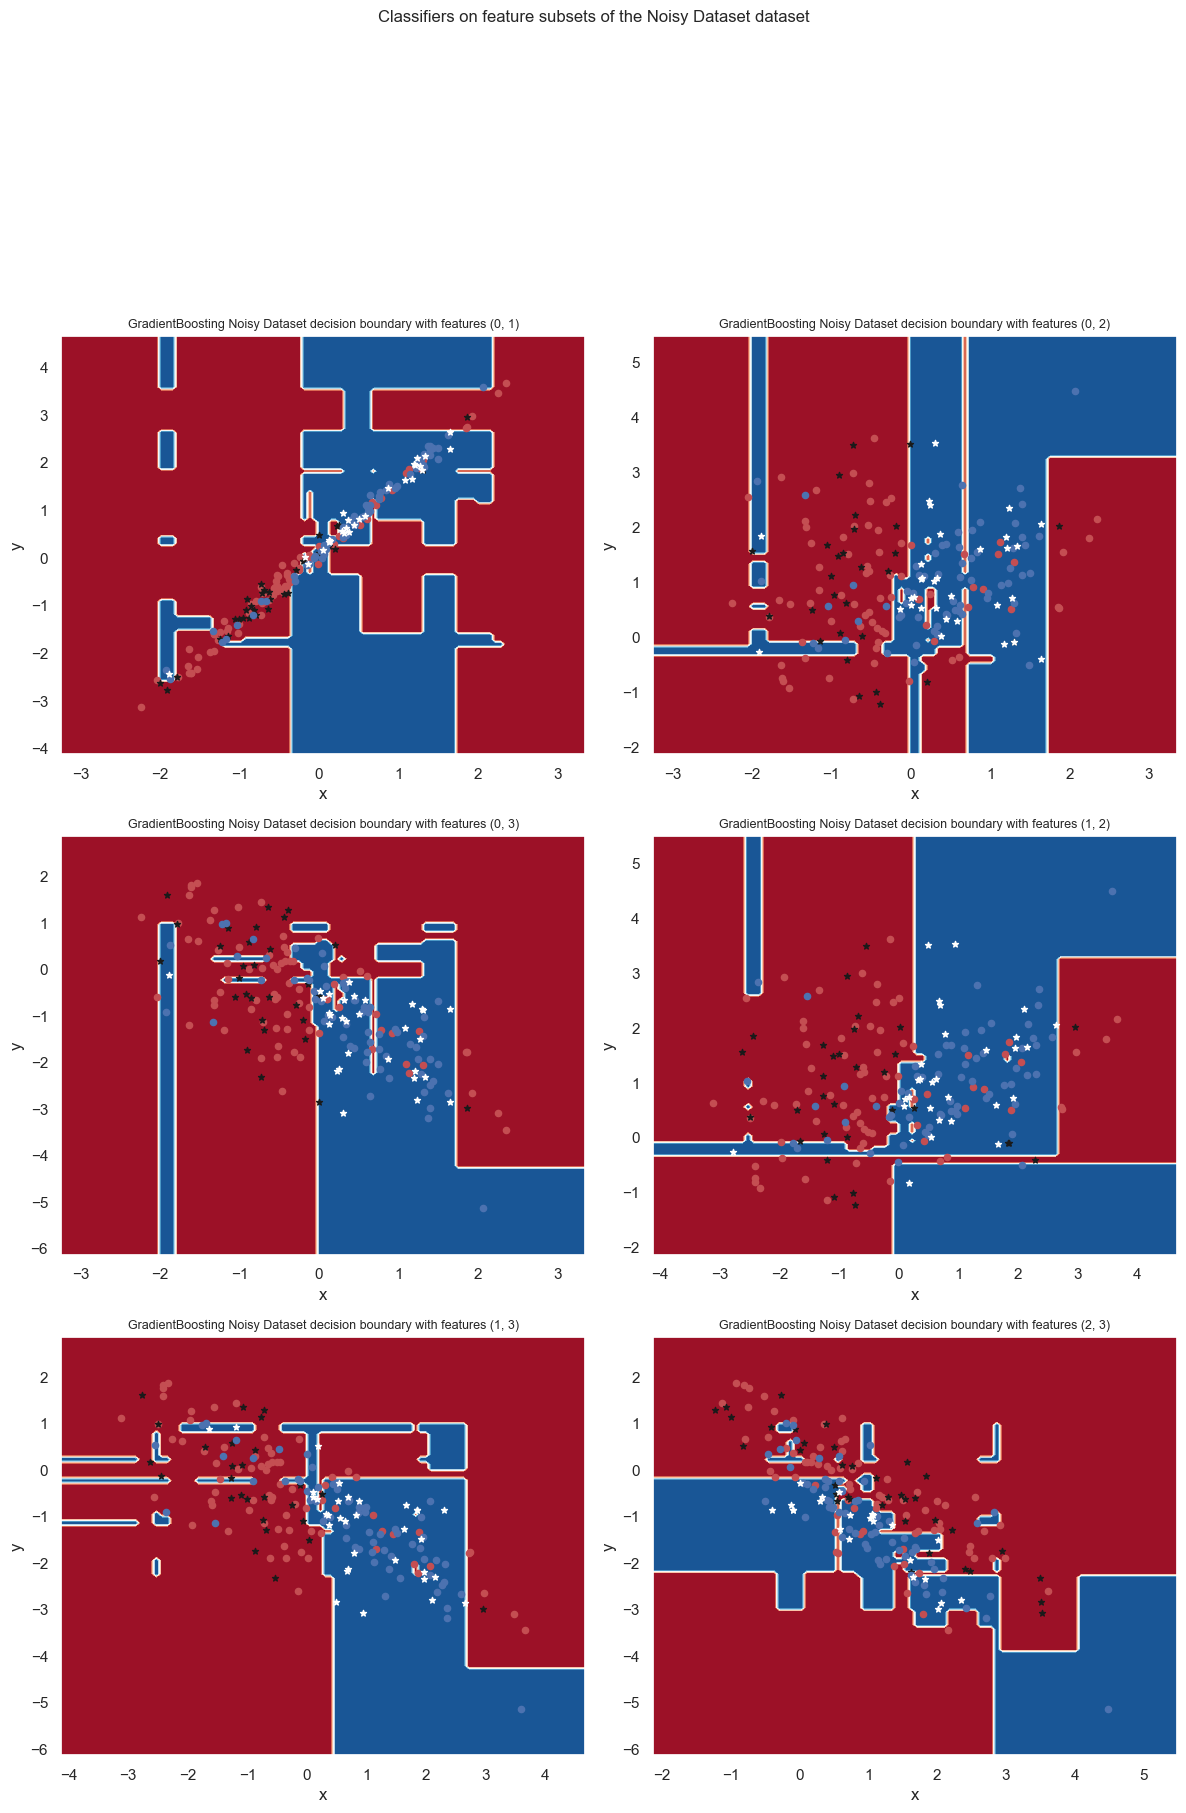

Accuracy of GradientBoosting:
Train:0.9357142857142857
Test:0.6


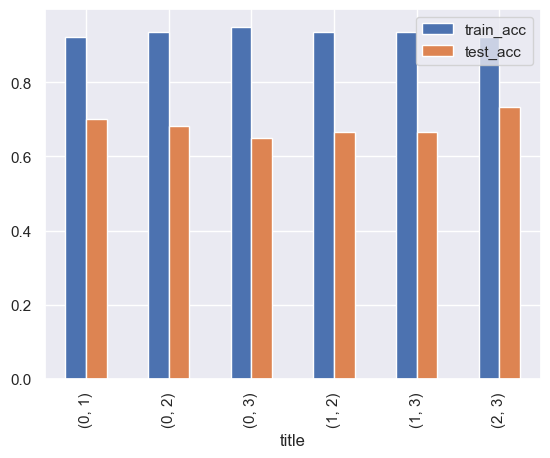

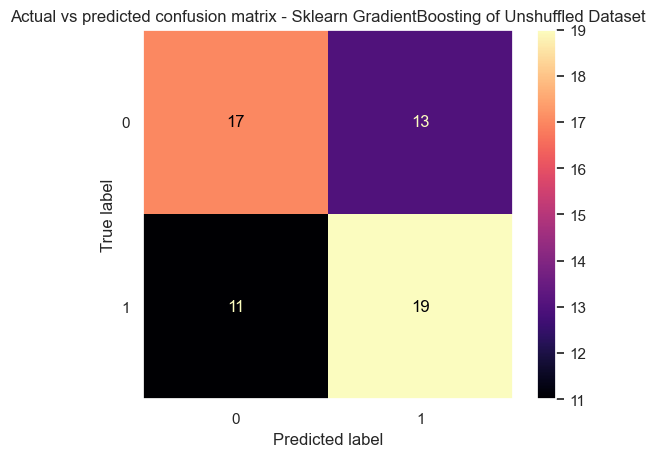

GradientBoosting Unshuffled Dataset with 100 estimators with features (0, 1) has a score of
Train: 0.9285714285714286
Test: 0.5333333333333333
GradientBoosting Unshuffled Dataset with 100 estimators with features (0, 2) has a score of
Train: 0.9214285714285714
Test: 0.5166666666666667
GradientBoosting Unshuffled Dataset with 100 estimators with features (0, 3) has a score of
Train: 0.9071428571428571
Test: 0.5166666666666667
GradientBoosting Unshuffled Dataset with 100 estimators with features (1, 2) has a score of
Train: 0.9214285714285714
Test: 0.55
GradientBoosting Unshuffled Dataset with 100 estimators with features (1, 3) has a score of
Train: 0.9285714285714286
Test: 0.6
GradientBoosting Unshuffled Dataset with 100 estimators with features (2, 3) has a score of
Train: 0.9214285714285714
Test: 0.5


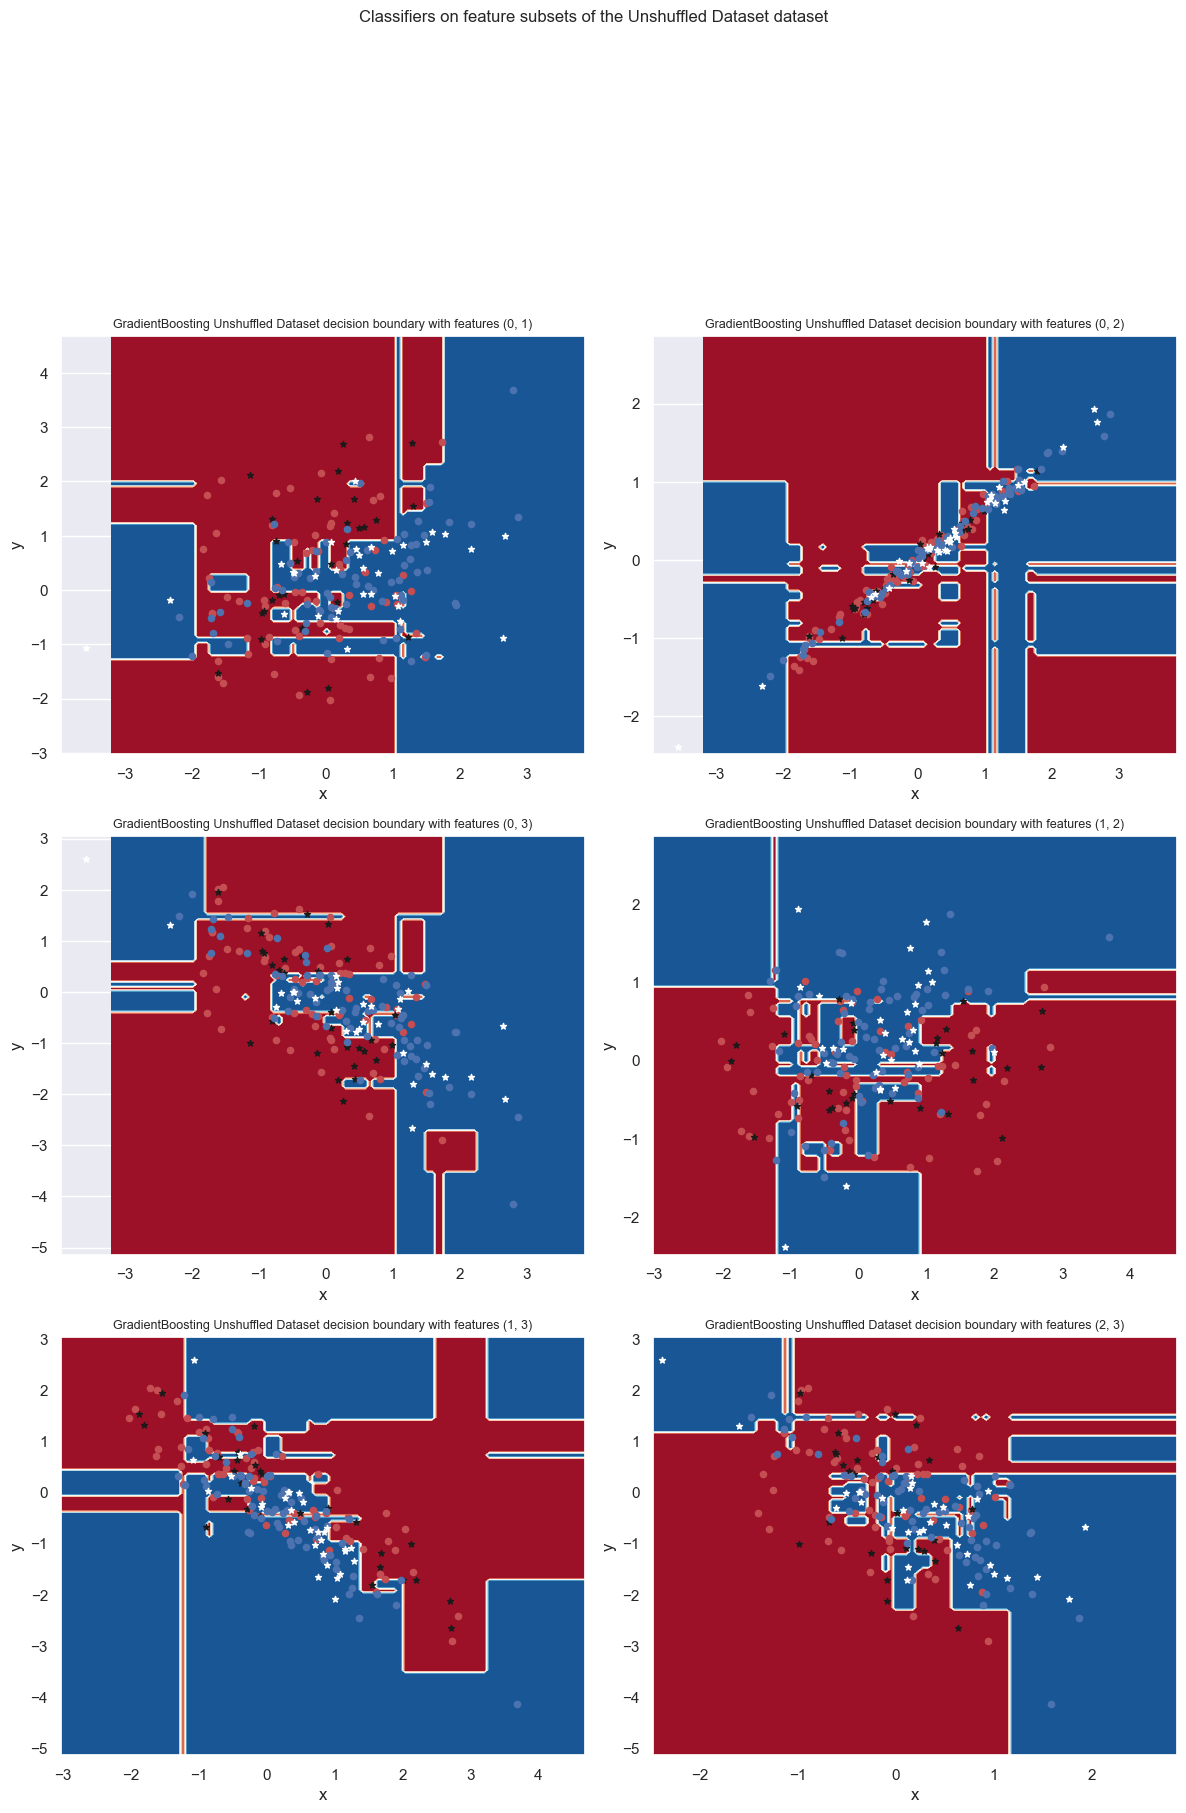

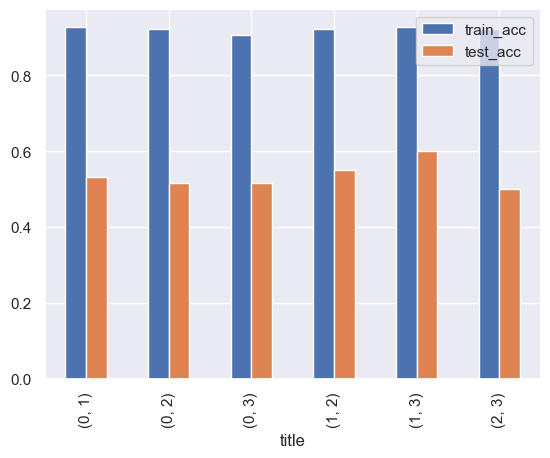

In [226]:
datasets = [{
    'n_samples': 200,
    'n_features': 4,
    'n_informative': 2,
    'n_classes': 2,
    'n_clusters_per_class': 1,
    'flip_y': 0.01, # Default flip value, no noise
    'class_sep': 0.2, # Reduces the space between label classes
    'title': "Low space Dataset"
},{
    'n_samples': 200,
    'n_features': 4,
    'n_informative': 2,
    'n_classes': 2,
    'n_clusters_per_class': 1,
    'flip_y': 0.3, # Makes a noisy dataset
    'class_sep': 1, # Default space seperation
    'title': "Noisy Dataset"
},{
    'n_samples': 200,
    'n_features': 4,
    'n_informative': 2,
    'n_classes': 2,
    'n_clusters_per_class': 1,
    'flip_y': 0.01, # Makes a noisy dataset
    'class_sep': 0.2, # Default space seperation
    'shuffle': False,
    'title': "Unshuffled Dataset"
}]

additional_models = [
    RandomForestClassifier(n_estimators=200, max_depth = 3, max_features='sqrt', random_state=42),
    GradientBoostingClassifier(n_estimators=100, max_depth = 3, learning_rate=0.05, random_state=42)
]

for additional_model in additional_models:
    for dataset in datasets:
        X, y = make_classification(
            n_samples = dataset['n_samples'],
            n_features = dataset['n_features'],
            n_informative = dataset['n_informative'],
            n_classes = dataset['n_classes'],
            n_clusters_per_class = dataset['n_clusters_per_class'],
            flip_y = dataset['flip_y'],
            class_sep = dataset['class_sep'],
            shuffle = dataset['shuffle'] if 'shuffle' in dataset else True,
            random_state=42
        )
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # 70% training and 30% test
            
        # Train Adaboost Classifer
        additional_res = additional_model.fit(X_train, y_train)

        #Predict the response for test dataset
        y_train_pred = additional_res.predict(X_train)
        y_pred = additional_res.predict(X_test)
    
        model_title = type(additional_model).__name__[: -len("Classifier")]

        accuracies_list.append({
            "title": f"{model_title} of {dataset['title']}",
            "train_acc": accuracy_score(y_train, y_train_pred),
            "test_acc": accuracy_score(y_test, y_pred)
        })
        
        # Model Accuracy, how often is the classifier correct?
        print(f"Accuracy of {model_title}:\nTrain:{accuracy_score(y_train, y_train_pred)}\nTest:{accuracy_score(y_test, y_pred)}")

        model_title = type(additional_model).__name__[: -len("Classifier")]
        matrix_plot = confusion_matrix(y_test, y_pred)
        cm_display = ConfusionMatrixDisplay(confusion_matrix=matrix_plot)
        cm_display.plot(cmap="magma")
        plt.title(
            f"Actual vs predicted confusion matrix - Sklearn {model_title} of {dataset['title']}"
        )
        plt.grid(False)
        plt.show()
        
        print_plots(additional_model, X_train, X_test, y_train, y_test, dataset['title'])

<Axes: xlabel='title'>

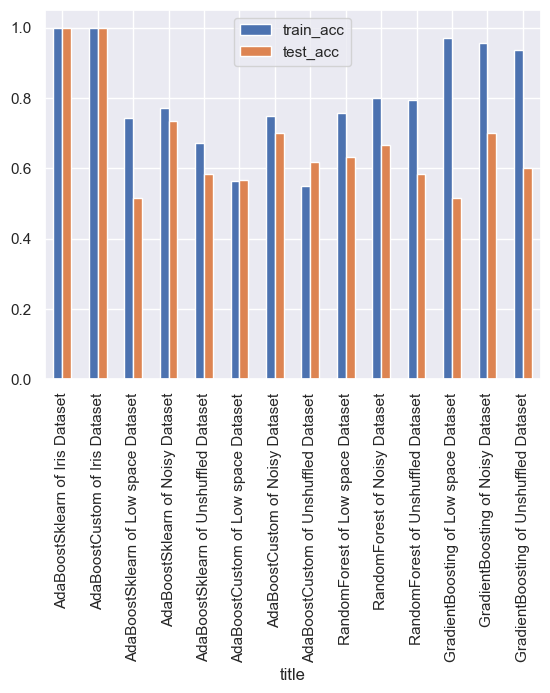

In [227]:
accuracies_list_df = pd.DataFrame.from_records(accuracies_list)
accuracies_list_df.plot.bar(x='title', y=['train_acc', 'test_acc'])

# Use of generative AI
Please use the cell below to describe your use of generative AI in this assignment. 

We used ChatGPT to help us in latex math functions, and also some plotting function names.